In [406]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib

In [407]:
all_tracking_tackles_play_defense = pd.read_csv("all_tracking_tackles_play_defense.csv")

In [408]:
all_tracking_tackles_play_defense['play_made'] = (
    (all_tracking_tackles_play_defense['tackle'] == 1) |
    (all_tracking_tackles_play_defense['assist'] == 1)
).astype(int)

all_tracking_tackles_play_defense['speed_diff'] = all_tracking_tackles_play_defense['s'] - all_tracking_tackles_play_defense['ball_carrier_speed']
all_tracking_tackles_play_defense['acc_diff'] = all_tracking_tackles_play_defense['a'] - all_tracking_tackles_play_defense['ball_carrier_acceleration']


keep_all = all_tracking_tackles_play_defense


#only take a sample of 300,000 frames
all_tracking_tackles_play_defense = train_test_split(all_tracking_tackles_play_defense, train_size=300000, stratify=all_tracking_tackles_play_defense['play_made'], random_state=42)[0]




In [409]:
all_tracking_tackles_play_defense['play_made'].value_counts()

play_made
0    264662
1     35338
Name: count, dtype: int64

In [410]:
def filter_after_handoff(df, event_column='handoff'):
    """
    Filters the dataset to only include frames occurring after the handoff.

    Args:
    df (pd.DataFrame): The tracking dataset containing frame data.
    event_column (str): The column indicating handoff event (1 if handoff occurred, 0 otherwise).

    Returns:
    pd.DataFrame: Filtered data containing only frames after the handoff.
    """
    filtered_data = []

    for _, group in df.groupby(['gameId', 'playId']):
        handoff_frames = group[group['event'] == "handoff"]['frameId']

        if not handoff_frames.empty:
            handoff_frame = handoff_frames.min()  # First frame when the handoff occurs
            after_handoff = group[group['frameId'] >= handoff_frame]  # Keep frames at or after handoff
            filtered_data.append(after_handoff)

    return pd.concat(filtered_data, ignore_index=True)




In [411]:
def filter_after_catch(df, event_column='pass_outcome_caught'):
    """
    Filters the dataset to only include frames occurring after the catch.

    Args:
    df (pd.DataFrame): The tracking dataset containing frame data.
    event_column (str): The column indicating catch event (1 if catch occurred, 0 otherwise).

    Returns:
    pd.DataFrame: Filtered data containing only frames after the catch.
    """
    filtered_data = []

    for _, group in df.groupby(['gameId', 'playId']):
        catch_frames = group[group['event'] == "pass_outcome_caught"]['frameId']

        if not catch_frames.empty:
            catch_frame = catch_frames.min()  # First frame when the catch occurs
            after_catch = group[group['frameId'] >= catch_frame]  # Keep frames at or after catch
            filtered_data.append(after_catch)

    return pd.concat(filtered_data, ignore_index=True)




In [412]:
df_after_catch = filter_after_catch(all_tracking_tackles_play_defense)
df_after_handoff = filter_after_handoff(all_tracking_tackles_play_defense)

In [413]:
features = ['s', 'a', 'o', 'dir',
       'ball_carrier_speed',
       'ball_carrier_acceleration',
       'ball_carrier_dir', 'ball_carrier_orientation', 'ball_carrier_height',
       'ball_carrier_weight', 'distance_to_ball_carrier',
       'defender_influence', 'blocker_influence', 'weight_diff',
       'height_diff', 'speed_diff', 'acc_diff']

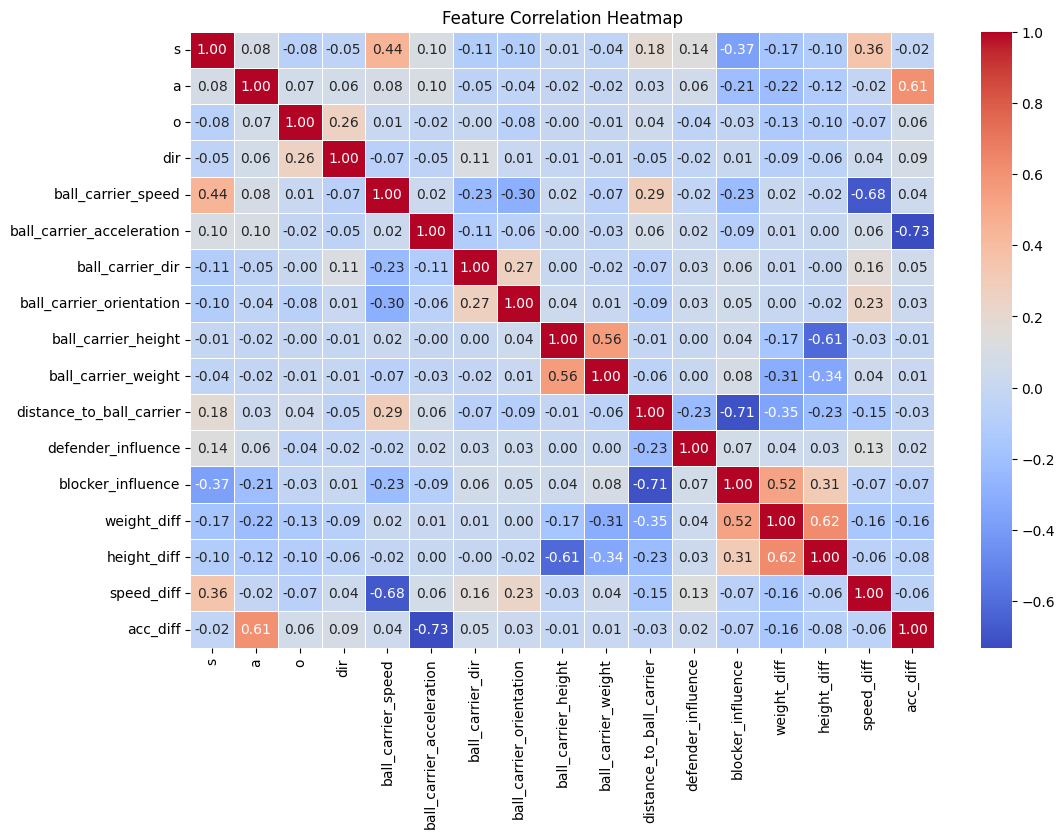

In [414]:
# Compute correlation matrix
correlation_matrix = df_after_handoff[features].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [415]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import train_test_split


def split_data(data, features):
  X = data[features]
  y = data['play_made']

  # Train (70%), Validation (15%), Test (15%) split
  X_train, X_temp, y_train, y_temp = train_test_split(
      X, y, test_size=0.3, random_state=42, stratify=y
  )
  X_val, X_test, y_val, y_test = train_test_split(
      X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
  )

  return X_train, X_val, X_test, y_train, y_val, y_test



def make_model(X_train, y_train, X_val, y_val):
  # Create pipeline
  estimators = [
    ('clf', XGBClassifier(random_state=8))
  ]
  clf = XGBClassifier(random_state=8)


  # Set up hyperparameter tuning
  search_space = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.001, 1.0, 'log-uniform'),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),
    'colsample_bylevel': Real(0.5, 1.0, 'uniform'),
    'colsample_bynode': Real(0.5, 1.0, 'uniform'),
    'gamma': Real(0.0, 0.5, 'uniform'),
    'reg_alpha': Real(0.0, 1.0, 'uniform'),
    'reg_lambda': Real(0.0, 1.0, 'uniform'),
    'max_delta_step': Integer(0, 10),
    'clf__scale_pos_weight': Real(0.1, 10.0, 'log-uniform'),

}


  opt = BayesSearchCV(
    clf, search_space, n_iter=32, cv=5, n_jobs=-1, random_state=8, scoring='roc_auc'
  )

  opt.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

  return opt


In [416]:
# Splitting data uniquely for each dataset
X_train_handoff, X_val_handoff, X_test_handoff, y_train_handoff, y_val_handoff, y_test_handoff = split_data(df_after_handoff, features)
after_handoff_model = make_model(X_train_handoff, y_train_handoff, X_val_handoff, y_val_handoff)

X_train_catch, X_val_catch, X_test_catch, y_train_catch, y_val_catch, y_test_catch = split_data(df_after_catch, features)
after_catch_model = make_model(X_train_catch, y_train_catch, X_val_catch, y_val_catch)

X_train_all, X_val_all, X_test_all, y_train_all, y_val_all, y_test_all = split_data(all_tracking_tackles_play_defense, features)
after_all_model = make_model(X_train_all, y_train_all, X_val_all, y_val_all)

import joblib

# Save models
joblib.dump(after_handoff_model, "after_handoff_model.pkl")
joblib.dump(after_catch_model, "after_catch_model.pkl")
joblib.dump(after_all_model, "after_all_model.pkl")



/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38169
[0]	validation_0-logloss:0.38169
[0]	validation_0-logloss:0.38191
[0]	validation_0-logloss:0.38184
[1]	validation_0-logloss:0.37513
[1]	validation_0-logloss:0.37500
[1]	validation_0-logloss:0.37523
[1]	validation_0-logloss:0.37539
[2]	validation_0-logloss:0.36997
[2]	validation_0-logloss:0.36977
[2]	validation_0-logloss:0.36996
[2]	validation_0-logloss:0.37038
[3]	validation_0-logloss:0.36486
[3]	validation_0-logloss:0.36527
[3]	validation_0-logloss:0.36496
[3]	validation_0-logloss:0.36573
[4]	validation_0-logloss:0.36011
[4]	validation_0-logloss:0.36043
[4]	validation_0-logloss:0.36013
[4]	validation_0-logloss:0.36091
[5]	validation_0-logloss:0.35594
[5]	validation_0-logloss:0.35587
[5]	validation_0-logloss:0.35616
[5]	validation_0-logloss:0.35658
[0]	validation_0-logloss:0.38172
[6]	validation_0-logloss:0.35171
[6]	validation_0-logloss:0.35161
[6]	validation_0-logloss:0.35197
[6]	validation_0-logloss:0.35242
[7]	validation_0-logloss:0.34783
[7]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	validation_0-logloss:0.36920
[37]	validation_0-logloss:0.36984
[38]	validation_0-logloss:0.36905
[38]	validation_0-logloss:0.36969
[39]	validation_0-logloss:0.36881
[39]	validation_0-logloss:0.36926
[40]	validation_0-logloss:0.36820
[40]	validation_0-logloss:0.36864
[41]	validation_0-logloss:0.36850
[41]	validation_0-logloss:0.36806
[42]	validation_0-logloss:0.36811
[42]	validation_0-logloss:0.36782
[43]	validation_0-logloss:0.36800
[43]	validation_0-logloss:0.36771
[44]	validation_0-logloss:0.36749
[44]	validation_0-logloss:0.36721
[45]	validation_0-logloss:0.36689
[45]	validation_0-logloss:0.36662
[46]	validation_0-logloss:0.36621
[46]	validation_0-logloss:0.36594
[47]	validation_0-logloss:0.36562
[47]	validation_0-logloss:0.36536
[48]	validation_0-logloss:0.36543
[48]	validation_0-logloss:0.36518
[49]	validation_0-logloss:0.36519
[49]	validation_0-logloss:0.36491
[50]	validation_0-logloss:0.36460
[50]	validation_0-logloss:0.36433
[51]	validation_0-logloss:0.36446
[51]	validatio

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.38732
[1]	validation_0-logloss:0.38699
[2]	validation_0-logloss:0.38677
[3]	validation_0-logloss:0.38595
[4]	validation_0-logloss:0.38546
[5]	validation_0-logloss:0.38528
[6]	validation_0-logloss:0.38491
[7]	validation_0-logloss:0.38407
[8]	validation_0-logloss:0.38387
[9]	validation_0-logloss:0.38321
[10]	validation_0-logloss:0.38257
[11]	validation_0-logloss:0.38235
[12]	validation_0-logloss:0.38175
[13]	validation_0-logloss:0.38154
[0]	validation_0-logloss:0.38750
[14]	validation_0-logloss:0.38090
[1]	validation_0-logloss:0.38727
[15]	validation_0-logloss:0.38003
[2]	validation_0-logloss:0.38704
[16]	validation_0-logloss:0.37929
[3]	validation_0-logloss:0.38623
[17]	validation_0-logloss:0.37865
[4]	validation_0-logloss:0.38573
[18]	validation_0-logloss:0.37792
[5]	validation_0-logloss:0.38554
[19]	validation_0-logloss:0.37729
[6]	validation_0-logloss:0.38518
[20]	validation_0-logloss:0.37648
[7]	validation_0-logloss:0.38433
[21]	validation_0-logloss:0.3763

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.38195
[11]	validation_0-logloss:0.38446
[23]	validation_0-logloss:0.38136
[21]	validation_0-logloss:0.38167
[12]	validation_0-logloss:0.38417
[24]	validation_0-logloss:0.38127
[13]	validation_0-logloss:0.38384
[22]	validation_0-logloss:0.38140
[25]	validation_0-logloss:0.38095
[14]	validation_0-logloss:0.38352
[23]	validation_0-logloss:0.38107
[26]	validation_0-logloss:0.38059
[15]	validation_0-logloss:0.38316
[24]	validation_0-logloss:0.38075
[27]	validation_0-logloss:0.38027
[16]	validation_0-logloss:0.38284
[25]	validation_0-logloss:0.38055
[28]	validation_0-logloss:0.37998
[17]	validation_0-logloss:0.38251
[26]	validation_0-logloss:0.38028
[29]	validation_0-logloss:0.37988
[18]	validation_0-logloss:0.38216
[27]	validation_0-logloss:0.37994
[30]	validation_0-logloss:0.37959
[19]	validation_0-logloss:0.38206
[28]	validation_0-logloss:0.37961
[20]	validation_0-logloss:0.38176
[31]	validation_0-logloss:0.37925
[29]	validation_0-logloss:0.37951
[21]	validatio

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-logloss:0.38607
[7]	validation_0-logloss:0.38601
[6]	validation_0-logloss:0.38582
[8]	validation_0-logloss:0.38594
[7]	validation_0-logloss:0.38547
[9]	validation_0-logloss:0.38563
[8]	validation_0-logloss:0.38536
[10]	validation_0-logloss:0.38540
[9]	validation_0-logloss:0.38501
[11]	validation_0-logloss:0.38509
[10]	validation_0-logloss:0.38464
[12]	validation_0-logloss:0.38479
[11]	validation_0-logloss:0.38432
[13]	validation_0-logloss:0.38450
[12]	validation_0-logloss:0.38405
[14]	validation_0-logloss:0.38421
[13]	validation_0-logloss:0.38395
[15]	validation_0-logloss:0.38386
[14]	validation_0-logloss:0.38378
[16]	validation_0-logloss:0.38368
[15]	validation_0-logloss:0.38345
[17]	validation_0-logloss:0.38337
[16]	validation_0-logloss:0.38333
[18]	validation_0-logloss:0.38300
[17]	validation_0-logloss:0.38302
[19]	validation_0-logloss:0.38289
[18]	validation_0-logloss:0.38283
[20]	validation_0-logloss:0.38256
[19]	validation_0-logloss:0.38273
[21]	validation_0-logl

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[16]	validation_0-logloss:0.31165
[20]	validation_0-logloss:0.30535
[5]	validation_0-logloss:0.34640
[12]	validation_0-logloss:0.32062
[17]	validation_0-logloss:0.30978
[21]	validation_0-logloss:0.30389
[6]	validation_0-logloss:0.34195
[13]	validation_0-logloss:0.31803
[18]	validation_0-logloss:0.30847
[22]	validation_0-logloss:0.30334
[7]	validation_0-logloss:0.33768
[14]	validation_0-logloss:0.31550
[19]	validation_0-logloss:0.30691
[23]	validation_0-logloss:0.30220
[8]	validation_0-logloss:0.33409
[15]	validation_0-logloss:0.31332
[20]	validation_0-logloss:0.30527
[24]	validation_0-logloss:0.30101
[9]	validation_0-logloss:0.33103
[16]	validation_0-logloss:0.31113
[21]	validation_0-logloss:0.30398
[25]	validation_0-logloss:0.29990
[10]	validation_0-logloss:0.32726
[17]	validation_0-logloss:0.30928
[22]	validation_0-logloss:0.30339
[26]	validation_0-logloss:0.29888
[11]	validation_0-logloss:0.32386
[18]	validation_0-logloss:0.30804
[23]	validation_0-logloss:0.30224
[27]	validation_0-l

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.37892
[1]	validation_0-logloss:0.37065
[2]	validation_0-logloss:0.36347
[3]	validation_0-logloss:0.35690
[4]	validation_0-logloss:0.35087
[5]	validation_0-logloss:0.34559
[6]	validation_0-logloss:0.34130
[7]	validation_0-logloss:0.33696
[8]	validation_0-logloss:0.33330
[9]	validation_0-logloss:0.33012
[10]	validation_0-logloss:0.32645
[11]	validation_0-logloss:0.32321
[12]	validation_0-logloss:0.32051
[13]	validation_0-logloss:0.31792
[14]	validation_0-logloss:0.31554
[15]	validation_0-logloss:0.31343
[16]	validation_0-logloss:0.31135
[17]	validation_0-logloss:0.30926
[18]	validation_0-logloss:0.30808
[19]	validation_0-logloss:0.30623
[20]	validation_0-logloss:0.30460
[21]	validation_0-logloss:0.30328
[22]	validation_0-logloss:0.30274
[23]	validation_0-logloss:0.30169
[24]	validation_0-logloss:0.30036
[25]	validation_0-logloss:0.29936
[26]	validation_0-logloss:0.29831
[27]	validation_0-logloss:0.29717
[28]	validation_0-logloss:0.29649
[29]	validation_0-loglos

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[24]	validation_0-logloss:0.29263
[23]	validation_0-logloss:0.29433
[32]	validation_0-logloss:0.29577
[25]	validation_0-logloss:0.29620
[31]	validation_0-logloss:0.29357
[25]	validation_0-logloss:0.29262
[24]	validation_0-logloss:0.29424
[26]	validation_0-logloss:0.29664
[26]	validation_0-logloss:0.29336
[33]	validation_0-logloss:0.29634
[32]	validation_0-logloss:0.29364
[25]	validation_0-logloss:0.29428
[27]	validation_0-logloss:0.29449
[34]	validation_0-logloss:0.29618
[27]	validation_0-logloss:0.29735
[33]	validation_0-logloss:0.29291
[26]	validation_0-logloss:0.29470
[28]	validation_0-logloss:0.29452
[35]	validation_0-logloss:0.29715
[28]	validation_0-logloss:0.29660
[34]	validation_0-logloss:0.29346
[27]	validation_0-logloss:0.29564
[29]	validation_0-logloss:0.29589
[36]	validation_0-logloss:0.29758
[29]	validation_0-logloss:0.29637
[35]	validation_0-logloss:0.29407
[28]	validation_0-logloss:0.29606
[30]	validation_0-logloss:0.29609
[37]	validation_0-logloss:0.29876
[30]	validatio

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[14]	validation_0-logloss:0.37793
[10]	validation_0-logloss:0.38083
[9]	validation_0-logloss:0.38138
[16]	validation_0-logloss:0.37689
[18]	validation_0-logloss:0.37601
[15]	validation_0-logloss:0.37730
[11]	validation_0-logloss:0.38017
[10]	validation_0-logloss:0.38073
[19]	validation_0-logloss:0.37537
[17]	validation_0-logloss:0.37636
[16]	validation_0-logloss:0.37665
[12]	validation_0-logloss:0.37956
[11]	validation_0-logloss:0.38012
[20]	validation_0-logloss:0.37516
[18]	validation_0-logloss:0.37577
[17]	validation_0-logloss:0.37601
[13]	validation_0-logloss:0.37891
[12]	validation_0-logloss:0.37948
[21]	validation_0-logloss:0.37472
[18]	validation_0-logloss:0.37540
[19]	validation_0-logloss:0.37513
[13]	validation_0-logloss:0.37929
[14]	validation_0-logloss:0.37825
[22]	validation_0-logloss:0.37416
[19]	validation_0-logloss:0.37485
[14]	validation_0-logloss:0.37863
[20]	validation_0-logloss:0.37454
[15]	validation_0-logloss:0.37765
[23]	validation_0-logloss:0.37354
[20]	validation

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37341
[1]	validation_0-logloss:0.36129
[2]	validation_0-logloss:0.35185
[3]	validation_0-logloss:0.34374
[4]	validation_0-logloss:0.33637
[0]	validation_0-logloss:0.37317
[5]	validation_0-logloss:0.33066
[1]	validation_0-logloss:0.36086
[6]	validation_0-logloss:0.32585
[2]	validation_0-logloss:0.35151
[0]	validation_0-logloss:0.37335
[7]	validation_0-logloss:0.32109
[3]	validation_0-logloss:0.34339
[1]	validation_0-logloss:0.36118
[8]	validation_0-logloss:0.31945
[4]	validation_0-logloss:0.33613
[2]	validation_0-logloss:0.35202
[9]	validation_0-logloss:0.31635
[3]	validation_0-logloss:0.34406
[5]	validation_0-logloss:0.33057
[10]	validation_0-logloss:0.31269
[6]	validation_0-logloss:0.32601
[0]	validation_0-logloss:0.37320
[4]	validation_0-logloss:0.33658
[11]	validation_0-logloss:0.30945
[7]	validation_0-logloss:0.32162
[1]	validation_0-logloss:0.36073
[5]	validation_0-logloss:0.33092
[12]	validation_0-logloss:0.30699
[8]	validation_0-logloss:0.32004
[0]	val

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[7]	validation_0-logloss:0.38610
[12]	validation_0-logloss:0.38482
[10]	validation_0-logloss:0.38536
[13]	validation_0-logloss:0.38461
[8]	validation_0-logloss:0.38585
[9]	validation_0-logloss:0.38559
[13]	validation_0-logloss:0.38457
[11]	validation_0-logloss:0.38511
[14]	validation_0-logloss:0.38437
[9]	validation_0-logloss:0.38560
[14]	validation_0-logloss:0.38433
[10]	validation_0-logloss:0.38534
[12]	validation_0-logloss:0.38487
[15]	validation_0-logloss:0.38412
[10]	validation_0-logloss:0.38536
[15]	validation_0-logloss:0.38408
[16]	validation_0-logloss:0.38388
[11]	validation_0-logloss:0.38509
[13]	validation_0-logloss:0.38463
[11]	validation_0-logloss:0.38511
[16]	validation_0-logloss:0.38383
[17]	validation_0-logloss:0.38363
[14]	validation_0-logloss:0.38438
[12]	validation_0-logloss:0.38483
[12]	validation_0-logloss:0.38487
[17]	validation_0-logloss:0.38360
[18]	validation_0-logloss:0.38339
[15]	validation_0-logloss:0.38414
[13]	validation_0-logloss:0.38458
[13]	validation_0-

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38743
[0]	validation_0-logloss:0.38757
[1]	validation_0-logloss:0.38652
[1]	validation_0-logloss:0.38656
[0]	validation_0-logloss:0.38747
[2]	validation_0-logloss:0.38574
[2]	validation_0-logloss:0.38577
[1]	validation_0-logloss:0.38651
[3]	validation_0-logloss:0.38543
[3]	validation_0-logloss:0.38487
[0]	validation_0-logloss:0.38739
[2]	validation_0-logloss:0.38628
[4]	validation_0-logloss:0.38454
[4]	validation_0-logloss:0.38397
[1]	validation_0-logloss:0.38644
[3]	validation_0-logloss:0.38530
[5]	validation_0-logloss:0.38370
[0]	validation_0-logloss:0.38731
[5]	validation_0-logloss:0.38307
[2]	validation_0-logloss:0.38549
[4]	validation_0-logloss:0.38441
[6]	validation_0-logloss:0.38280
[6]	validation_0-logloss:0.38211
[1]	validation_0-logloss:0.38709
[5]	validation_0-logloss:0.38346
[3]	validation_0-logloss:0.38520
[7]	validation_0-logloss:0.38252
[7]	validation_0-logloss:0.38132
[2]	validation_0-logloss:0.38682
[6]	validation_0-logloss:0.38270
[4]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38109
[0]	validation_0-logloss:0.38129
[1]	validation_0-logloss:0.37424
[1]	validation_0-logloss:0.37447
[0]	validation_0-logloss:0.38084
[0]	validation_0-logloss:0.38097
[2]	validation_0-logloss:0.36820
[2]	validation_0-logloss:0.36874
[0]	validation_0-logloss:0.38072
[1]	validation_0-logloss:0.37439
[1]	validation_0-logloss:0.37389
[3]	validation_0-logloss:0.36321
[3]	validation_0-logloss:0.36269
[1]	validation_0-logloss:0.37392
[2]	validation_0-logloss:0.36840
[2]	validation_0-logloss:0.36784
[4]	validation_0-logloss:0.35798
[4]	validation_0-logloss:0.35741
[2]	validation_0-logloss:0.36780
[3]	validation_0-logloss:0.36201
[3]	validation_0-logloss:0.36300
[5]	validation_0-logloss:0.35336
[5]	validation_0-logloss:0.35246
[3]	validation_0-logloss:0.36238
[4]	validation_0-logloss:0.35682
[4]	validation_0-logloss:0.35785
[6]	validation_0-logloss:0.34896
[6]	validation_0-logloss:0.34801
[4]	validation_0-logloss:0.35719
[5]	validation_0-logloss:0.35218
[5]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37874
[0]	validation_0-logloss:0.37885
[1]	validation_0-logloss:0.37035
[1]	validation_0-logloss:0.37060
[2]	validation_0-logloss:0.36262
[0]	validation_0-logloss:0.37837
[2]	validation_0-logloss:0.36277
[3]	validation_0-logloss:0.35537
[1]	validation_0-logloss:0.37538
[3]	validation_0-logloss:0.35691
[4]	validation_0-logloss:0.34902
[2]	validation_0-logloss:0.36712
[4]	validation_0-logloss:0.35061
[5]	validation_0-logloss:0.34555
[3]	validation_0-logloss:0.35963
[0]	validation_0-logloss:0.37844
[5]	validation_0-logloss:0.34482
[6]	validation_0-logloss:0.34031
[4]	validation_0-logloss:0.35285
[1]	validation_0-logloss:0.37130
[6]	validation_0-logloss:0.33986
[7]	validation_0-logloss:0.33508
[5]	validation_0-logloss:0.34702
[2]	validation_0-logloss:0.36404
[7]	validation_0-logloss:0.33631
[8]	validation_0-logloss:0.33248
[6]	validation_0-logloss:0.34163
[3]	validation_0-logloss:0.35767
[8]	validation_0-logloss:0.33176
[0]	validation_0-logloss:0.37832
[9]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37841
[1]	validation_0-logloss:0.37144
[2]	validation_0-logloss:0.36379
[3]	validation_0-logloss:0.35707
[0]	validation_0-logloss:0.37864
[4]	validation_0-logloss:0.35124
[1]	validation_0-logloss:0.37164
[5]	validation_0-logloss:0.34653
[2]	validation_0-logloss:0.36392
[6]	validation_0-logloss:0.34183
[3]	validation_0-logloss:0.35708
[7]	validation_0-logloss:0.33825
[4]	validation_0-logloss:0.35115
[0]	validation_0-logloss:0.37840
[8]	validation_0-logloss:0.33447
[5]	validation_0-logloss:0.34633
[1]	validation_0-logloss:0.37145
[9]	validation_0-logloss:0.33099
[6]	validation_0-logloss:0.34169
[2]	validation_0-logloss:0.36377
[10]	validation_0-logloss:0.32763
[7]	validation_0-logloss:0.33781
[3]	validation_0-logloss:0.35716
[11]	validation_0-logloss:0.32465
[8]	validation_0-logloss:0.33418
[4]	validation_0-logloss:0.35141
[12]	validation_0-logloss:0.32218
[9]	validation_0-logloss:0.33105
[5]	validation_0-logloss:0.34660
[13]	validation_0-logloss:0.31964
[10]	v

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.32684
[0]	validation_0-logloss:0.33262
[1]	validation_0-logloss:0.32705
[1]	validation_0-logloss:0.33262
[2]	validation_0-logloss:0.33651
[2]	validation_0-logloss:0.33981
[3]	validation_0-logloss:0.34909
[3]	validation_0-logloss:0.35107
[0]	validation_0-logloss:0.33165
[4]	validation_0-logloss:0.35898
[4]	validation_0-logloss:0.35913
[0]	validation_0-logloss:0.33530
[5]	validation_0-logloss:0.36660
[5]	validation_0-logloss:0.36451
[1]	validation_0-logloss:0.32604
[6]	validation_0-logloss:0.38177
[1]	validation_0-logloss:0.33620
[6]	validation_0-logloss:0.37888
[2]	validation_0-logloss:0.33479
[7]	validation_0-logloss:0.38565
[2]	validation_0-logloss:0.34135
[3]	validation_0-logloss:0.33729
[7]	validation_0-logloss:0.38918
[8]	validation_0-logloss:0.38945
[3]	validation_0-logloss:0.35022
[4]	validation_0-logloss:0.35363
[8]	validation_0-logloss:0.39402
[9]	validation_0-logloss:0.39989
[4]	validation_0-logloss:0.36193
[10]	validation_0-logloss:0.40645
[9]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-logloss:0.37562
[7]	validation_0-logloss:0.38774
[8]	validation_0-logloss:0.39539
[9]	validation_0-logloss:0.40828
[10]	validation_0-logloss:0.41071
[11]	validation_0-logloss:0.41813
[12]	validation_0-logloss:0.42695
[13]	validation_0-logloss:0.43543
[14]	validation_0-logloss:0.45215
[15]	validation_0-logloss:0.46280
[16]	validation_0-logloss:0.47232
[17]	validation_0-logloss:0.48186
[18]	validation_0-logloss:0.49182
[19]	validation_0-logloss:0.50838
[20]	validation_0-logloss:0.51851
[21]	validation_0-logloss:0.52656
[22]	validation_0-logloss:0.53251
[23]	validation_0-logloss:0.54134
[24]	validation_0-logloss:0.54184
[25]	validation_0-logloss:0.55552
[26]	validation_0-logloss:0.56033
[27]	validation_0-logloss:0.56586
[28]	validation_0-logloss:0.57262
[29]	validation_0-logloss:0.57816
[30]	validation_0-logloss:0.57886
[31]	validation_0-logloss:0.58697
[32]	validation_0-logloss:0.59386
[33]	validation_0-logloss:0.59633
[34]	validation_0-logloss:0.59966
[35]	validation_0-

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38580
[0]	validation_0-logloss:0.38581
[1]	validation_0-logloss:0.38331
[2]	validation_0-logloss:0.38263
[1]	validation_0-logloss:0.38518
[0]	validation_0-logloss:0.38562
[3]	validation_0-logloss:0.38062
[2]	validation_0-logloss:0.38287
[1]	validation_0-logloss:0.38357
[4]	validation_0-logloss:0.37990
[3]	validation_0-logloss:0.38111
[2]	validation_0-logloss:0.38121
[5]	validation_0-logloss:0.37767
[0]	validation_0-logloss:0.38573
[4]	validation_0-logloss:0.37865
[3]	validation_0-logloss:0.37913
[6]	validation_0-logloss:0.37700
[0]	validation_0-logloss:0.38575
[5]	validation_0-logloss:0.37644
[4]	validation_0-logloss:0.37842
[1]	validation_0-logloss:0.38322
[6]	validation_0-logloss:0.37501
[7]	validation_0-logloss:0.37479
[5]	validation_0-logloss:0.37772
[1]	validation_0-logloss:0.38491
[2]	validation_0-logloss:0.38085
[8]	validation_0-logloss:0.37268
[7]	validation_0-logloss:0.37305
[6]	validation_0-logloss:0.37573
[2]	validation_0-logloss:0.38281
[3]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38373
[1]	validation_0-logloss:0.37971
[2]	validation_0-logloss:0.37589
[0]	validation_0-logloss:0.38368
[3]	validation_0-logloss:0.37228
[1]	validation_0-logloss:0.37970
[4]	validation_0-logloss:0.36876
[0]	validation_0-logloss:0.38382
[2]	validation_0-logloss:0.37587
[5]	validation_0-logloss:0.36532
[1]	validation_0-logloss:0.37971
[3]	validation_0-logloss:0.37221
[6]	validation_0-logloss:0.36219
[2]	validation_0-logloss:0.37580
[4]	validation_0-logloss:0.36866
[0]	validation_0-logloss:0.38368
[7]	validation_0-logloss:0.35913
[3]	validation_0-logloss:0.37220
[5]	validation_0-logloss:0.36525
[1]	validation_0-logloss:0.37955
[8]	validation_0-logloss:0.35626
[0]	validation_0-logloss:0.38372
[4]	validation_0-logloss:0.36873
[6]	validation_0-logloss:0.36210
[2]	validation_0-logloss:0.37560
[9]	validation_0-logloss:0.35349
[5]	validation_0-logloss:0.36524
[1]	validation_0-logloss:0.37957
[7]	validation_0-logloss:0.35907
[3]	validation_0-logloss:0.37189
[10]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38801
[0]	validation_0-logloss:0.38801
[1]	validation_0-logloss:0.38790
[1]	validation_0-logloss:0.38796
[0]	validation_0-logloss:0.38801
[2]	validation_0-logloss:0.38785
[2]	validation_0-logloss:0.38784
[0]	validation_0-logloss:0.38800
[1]	validation_0-logloss:0.38790
[3]	validation_0-logloss:0.38774
[3]	validation_0-logloss:0.38772
[1]	validation_0-logloss:0.38789
[2]	validation_0-logloss:0.38779
[4]	validation_0-logloss:0.38761
[0]	validation_0-logloss:0.38800
[4]	validation_0-logloss:0.38768
[2]	validation_0-logloss:0.38777
[5]	validation_0-logloss:0.38750
[5]	validation_0-logloss:0.38757
[3]	validation_0-logloss:0.38773
[1]	validation_0-logloss:0.38794
[3]	validation_0-logloss:0.38765
[6]	validation_0-logloss:0.38738
[6]	validation_0-logloss:0.38751
[4]	validation_0-logloss:0.38754
[2]	validation_0-logloss:0.38783
[7]	validation_0-logloss:0.38726
[4]	validation_0-logloss:0.38767
[7]	validation_0-logloss:0.38740
[3]	validation_0-logloss:0.38771
[5]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.34301
[0]	validation_0-logloss:0.34144
[1]	validation_0-logloss:0.32579
[1]	validation_0-logloss:0.32536
[2]	validation_0-logloss:0.32268
[2]	validation_0-logloss:0.32410
[3]	validation_0-logloss:0.31495
[3]	validation_0-logloss:0.31705
[4]	validation_0-logloss:0.31359
[4]	validation_0-logloss:0.31383
[5]	validation_0-logloss:0.31273
[5]	validation_0-logloss:0.31130
[6]	validation_0-logloss:0.31271
[6]	validation_0-logloss:0.30963[0]	validation_0-logloss:0.34305

[7]	validation_0-logloss:0.30219
[7]	validation_0-logloss:0.29882
[1]	validation_0-logloss:0.32948
[8]	validation_0-logloss:0.30143
[2]	validation_0-logloss:0.32724
[8]	validation_0-logloss:0.29808
[9]	validation_0-logloss:0.30137
[3]	validation_0-logloss:0.32176
[9]	validation_0-logloss:0.29745
[10]	validation_0-logloss:0.30200
[10]	validation_0-logloss:0.29689
[4]	validation_0-logloss:0.31928
[11]	validation_0-logloss:0.30186
[11]	validation_0-logloss:0.29681
[5]	validation_0-logloss:0.31699
[0]	va

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37915
[0]	validation_0-logloss:0.37946
[1]	validation_0-logloss:0.37205
[1]	validation_0-logloss:0.37068
[2]	validation_0-logloss:0.36344
[0]	validation_0-logloss:0.37913
[2]	validation_0-logloss:0.36241
[3]	validation_0-logloss:0.35580
[1]	validation_0-logloss:0.37001
[4]	validation_0-logloss:0.34894
[3]	validation_0-logloss:0.35654
[0]	validation_0-logloss:0.37967
[2]	validation_0-logloss:0.36188
[5]	validation_0-logloss:0.34576
[4]	validation_0-logloss:0.35305
[6]	validation_0-logloss:0.33931
[3]	validation_0-logloss:0.35884
[1]	validation_0-logloss:0.37495
[5]	validation_0-logloss:0.34973
[7]	validation_0-logloss:0.33427
[4]	validation_0-logloss:0.35665
[2]	validation_0-logloss:0.36584
[6]	validation_0-logloss:0.34739
[0]	validation_0-logloss:0.37939
[5]	validation_0-logloss:0.34963
[3]	validation_0-logloss:0.35948
[8]	validation_0-logloss:0.32873
[7]	validation_0-logloss:0.34090
[6]	validation_0-logloss:0.34347
[4]	validation_0-logloss:0.35674
[1]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38797
[1]	validation_0-logloss:0.38781
[2]	validation_0-logloss:0.38765
[3]	validation_0-logloss:0.38748
[4]	validation_0-logloss:0.38733
[5]	validation_0-logloss:0.38730
[0]	validation_0-logloss:0.38797
[6]	validation_0-logloss:0.38724
[1]	validation_0-logloss:0.38781
[7]	validation_0-logloss:0.38713
[2]	validation_0-logloss:0.38765
[8]	validation_0-logloss:0.38699
[3]	validation_0-logloss:0.38749
[9]	validation_0-logloss:0.38683
[4]	validation_0-logloss:0.38734
[10]	validation_0-logloss:0.38668
[5]	validation_0-logloss:0.38730
[11]	validation_0-logloss:0.38653
[6]	validation_0-logloss:0.38725
[12]	validation_0-logloss:0.38637
[0]	validation_0-logloss:0.38796
[7]	validation_0-logloss:0.38713
[13]	validation_0-logloss:0.38623
[8]	validation_0-logloss:0.38700
[1]	validation_0-logloss:0.38780
[14]	validation_0-logloss:0.38607
[9]	validation_0-logloss:0.38684
[2]	validation_0-logloss:0.38764
[15]	validation_0-logloss:0.38591
[10]	validation_0-logloss:0.38669
[3]

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38551
[1]	validation_0-logloss:0.37885
[0]	validation_0-logloss:0.38271
[2]	validation_0-logloss:0.37686
[1]	validation_0-logloss:0.37778
[3]	validation_0-logloss:0.37476
[2]	validation_0-logloss:0.37542
[4]	validation_0-logloss:0.37301
[3]	validation_0-logloss:0.37098
[0]	validation_0-logloss:0.38326
[5]	validation_0-logloss:0.36612
[4]	validation_0-logloss:0.36563
[1]	validation_0-logloss:0.37542
[0]	validation_0-logloss:0.38510
[6]	validation_0-logloss:0.36178
[5]	validation_0-logloss:0.36005
[2]	validation_0-logloss:0.36877
[7]	validation_0-logloss:0.35707
[1]	validation_0-logloss:0.37870
[6]	validation_0-logloss:0.35521
[3]	validation_0-logloss:0.36269
[2]	validation_0-logloss:0.37135
[8]	validation_0-logloss:0.35159
[4]	validation_0-logloss:0.35703
[7]	validation_0-logloss:0.35097
[3]	validation_0-logloss:0.36479
[9]	validation_0-logloss:0.34773
[5]	validation_0-logloss:0.35505
[8]	validation_0-logloss:0.34898
[4]	validation_0-logloss:0.36323
[10]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-logloss:0.31679
[20]	validation_0-logloss:0.31434
[21]	validation_0-logloss:0.31264
[22]	validation_0-logloss:0.31181
[23]	validation_0-logloss:0.30969
[24]	validation_0-logloss:0.30798
[25]	validation_0-logloss:0.30621
[26]	validation_0-logloss:0.30465
[27]	validation_0-logloss:0.30394
[28]	validation_0-logloss:0.30334
[29]	validation_0-logloss:0.30279
[30]	validation_0-logloss:0.30118
[31]	validation_0-logloss:0.30074
[32]	validation_0-logloss:0.29997
[33]	validation_0-logloss:0.29953
[34]	validation_0-logloss:0.29911
[35]	validation_0-logloss:0.29866
[36]	validation_0-logloss:0.29734
[37]	validation_0-logloss:0.29643
[38]	validation_0-logloss:0.29584
[39]	validation_0-logloss:0.29476
[40]	validation_0-logloss:0.29356
[41]	validation_0-logloss:0.29270
[42]	validation_0-logloss:0.29239
[43]	validation_0-logloss:0.29147
[44]	validation_0-logloss:0.29064
[45]	validation_0-logloss:0.29046
[46]	validation_0-logloss:0.28995
[47]	validation_0-logloss:0.28952
[48]	validatio

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37975
[0]	validation_0-logloss:0.37974
[1]	validation_0-logloss:0.37186
[1]	validation_0-logloss:0.37186
[0]	validation_0-logloss:0.37948
[2]	validation_0-logloss:0.36892
[2]	validation_0-logloss:0.36910
[3]	validation_0-logloss:0.36156
[1]	validation_0-logloss:0.37147
[3]	validation_0-logloss:0.36199
[0]	validation_0-logloss:0.37986
[4]	validation_0-logloss:0.35523
[4]	validation_0-logloss:0.35569
[2]	validation_0-logloss:0.36861
[1]	validation_0-logloss:0.37220
[5]	validation_0-logloss:0.35334
[3]	validation_0-logloss:0.36132
[5]	validation_0-logloss:0.35380
[6]	validation_0-logloss:0.34871
[2]	validation_0-logloss:0.36930
[0]	validation_0-logloss:0.37970
[6]	validation_0-logloss:0.34890
[4]	validation_0-logloss:0.35464
[7]	validation_0-logloss:0.34408
[3]	validation_0-logloss:0.36207
[1]	validation_0-logloss:0.37195
[7]	validation_0-logloss:0.34430
[8]	validation_0-logloss:0.34052
[5]	validation_0-logloss:0.35274
[4]	validation_0-logloss:0.35553
[2]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38102
[0]	validation_0-logloss:0.38089
[1]	validation_0-logloss:0.37377[0]	validation_0-logloss:0.38070

[1]	validation_0-logloss:0.37398
[2]	validation_0-logloss:0.36751
[1]	validation_0-logloss:0.37374
[2]	validation_0-logloss:0.36780
[0]	validation_0-logloss:0.38084
[2]	validation_0-logloss:0.36757
[3]	validation_0-logloss:0.36165
[0]	validation_0-logloss:0.38079
[3]	validation_0-logloss:0.36209
[1]	validation_0-logloss:0.37391
[4]	validation_0-logloss:0.35635
[3]	validation_0-logloss:0.36190
[1]	validation_0-logloss:0.37378
[4]	validation_0-logloss:0.35679
[2]	validation_0-logloss:0.36753
[4]	validation_0-logloss:0.35646
[5]	validation_0-logloss:0.35142
[2]	validation_0-logloss:0.36758
[5]	validation_0-logloss:0.35168
[3]	validation_0-logloss:0.36180
[5]	validation_0-logloss:0.35170
[3]	validation_0-logloss:0.36195
[6]	validation_0-logloss:0.34698
[6]	validation_0-logloss:0.34704
[4]	validation_0-logloss:0.35644
[6]	validation_0-logloss:0.34730
[7]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37896
[0]	validation_0-logloss:0.37864
[1]	validation_0-logloss:0.37558
[0]	validation_0-logloss:0.37898
[0]	validation_0-logloss:0.37887
[2]	validation_0-logloss:0.36756
[1]	validation_0-logloss:0.37102
[1]	validation_0-logloss:0.37614
[0]	validation_0-logloss:0.37863
[1]	validation_0-logloss:0.37126
[3]	validation_0-logloss:0.36018
[2]	validation_0-logloss:0.36364
[2]	validation_0-logloss:0.36446
[4]	validation_0-logloss:0.35390
[3]	validation_0-logloss:0.36067
[2]	validation_0-logloss:0.37388
[1]	validation_0-logloss:0.37090
[5]	validation_0-logloss:0.34812
[3]	validation_0-logloss:0.35815
[3]	validation_0-logloss:0.37125
[4]	validation_0-logloss:0.35818
[2]	validation_0-logloss:0.36369
[4]	validation_0-logloss:0.35238
[6]	validation_0-logloss:0.34282
[4]	validation_0-logloss:0.36387
[5]	validation_0-logloss:0.35197
[3]	validation_0-logloss:0.35676
[5]	validation_0-logloss:0.35747
[5]	validation_0-logloss:0.35022
[4]	validation_0-logloss:0.35092
[6]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36208
[1]	validation_0-logloss:0.34217
[0]	validation_0-logloss:0.36204
[2]	validation_0-logloss:0.32816
[1]	validation_0-logloss:0.34207
[3]	validation_0-logloss:0.31630
[2]	validation_0-logloss:0.32808
[4]	validation_0-logloss:0.30857
[3]	validation_0-logloss:0.31671
[4]	validation_0-logloss:0.30839
[5]	validation_0-logloss:0.30801
[5]	validation_0-logloss:0.30738
[6]	validation_0-logloss:0.30209
[6]	validation_0-logloss:0.30220
[7]	validation_0-logloss:0.29908
[7]	validation_0-logloss:0.29906
[8]	validation_0-logloss:0.29587
[0]	validation_0-logloss:0.36160
[8]	validation_0-logloss:0.29592
[9]	validation_0-logloss:0.29367
[1]	validation_0-logloss:0.34212
[9]	validation_0-logloss:0.29356
[10]	validation_0-logloss:0.29238
[2]	validation_0-logloss:0.32801
[10]	validation_0-logloss:0.29242
[11]	validation_0-logloss:0.29104
[3]	validation_0-logloss:0.31655
[11]	validation_0-logloss:0.29073
[12]	validation_0-logloss:0.29086
[4]	validation_0-logloss:0.30807
[12]	

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37953
[0]	validation_0-logloss:0.37960
[1]	validation_0-logloss:0.37113
[1]	validation_0-logloss:0.37219
[2]	validation_0-logloss:0.36387
[0]	validation_0-logloss:0.37931
[2]	validation_0-logloss:0.36359
[3]	validation_0-logloss:0.35653
[1]	validation_0-logloss:0.37187
[3]	validation_0-logloss:0.35607
[4]	validation_0-logloss:0.35145
[2]	validation_0-logloss:0.36344
[4]	validation_0-logloss:0.35398
[5]	validation_0-logloss:0.34526
[3]	validation_0-logloss:0.36092
[5]	validation_0-logloss:0.35225
[0]	validation_0-logloss:0.37932
[6]	validation_0-logloss:0.33968
[4]	validation_0-logloss:0.35557
[6]	validation_0-logloss:0.34585
[1]	validation_0-logloss:0.37102
[7]	validation_0-logloss:0.33806
[5]	validation_0-logloss:0.34888
[7]	validation_0-logloss:0.33997
[2]	validation_0-logloss:0.36253
[8]	validation_0-logloss:0.33650
[6]	validation_0-logloss:0.34300
[8]	validation_0-logloss:0.33527
[9]	validation_0-logloss:0.33274
[3]	validation_0-logloss:0.36004
[7]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38807
[1]	validation_0-logloss:0.38803
[2]	validation_0-logloss:0.38787
[0]	validation_0-logloss:0.38808
[3]	validation_0-logloss:0.38773
[4]	validation_0-logloss:0.38768
[1]	validation_0-logloss:0.38803
[5]	validation_0-logloss:0.38752
[2]	validation_0-logloss:0.38792
[6]	validation_0-logloss:0.38747
[3]	validation_0-logloss:0.38788
[0]	validation_0-logloss:0.38808
[7]	validation_0-logloss:0.38734
[4]	validation_0-logloss:0.38785
[8]	validation_0-logloss:0.38725
[5]	validation_0-logloss:0.38771
[1]	validation_0-logloss:0.38802
[9]	validation_0-logloss:0.38720
[6]	validation_0-logloss:0.38759
[2]	validation_0-logloss:0.38798
[10]	validation_0-logloss:0.38704
[7]	validation_0-logloss:0.38743
[0]	validation_0-logloss:0.38806
[3]	validation_0-logloss:0.38784
[11]	validation_0-logloss:0.38699
[1]	validation_0-logloss:0.38802
[4]	validation_0-logloss:0.38774
[12]	validation_0-logloss:0.38695
[8]	validation_0-logloss:0.38739
[0]	validation_0-logloss:0.38807
[2]	val

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38593
[0]	validation_0-logloss:0.38591
[1]	validation_0-logloss:0.38366
[1]	validation_0-logloss:0.38387
[2]	validation_0-logloss:0.38152
[0]	validation_0-logloss:0.38585
[2]	validation_0-logloss:0.38316
[3]	validation_0-logloss:0.37941
[1]	validation_0-logloss:0.38360
[3]	validation_0-logloss:0.38161
[2]	validation_0-logloss:0.38141
[4]	validation_0-logloss:0.37964
[4]	validation_0-logloss:0.37767
[3]	validation_0-logloss:0.37942
[5]	validation_0-logloss:0.37776
[5]	validation_0-logloss:0.37583
[4]	validation_0-logloss:0.37750
[0]	validation_0-logloss:0.38595
[6]	validation_0-logloss:0.37577
[6]	validation_0-logloss:0.37396
[5]	validation_0-logloss:0.37561
[1]	validation_0-logloss:0.38387
[7]	validation_0-logloss:0.37526
[7]	validation_0-logloss:0.37235
[6]	validation_0-logloss:0.37387
[2]	validation_0-logloss:0.38317
[8]	validation_0-logloss:0.37339
[8]	validation_0-logloss:0.37054
[3]	validation_0-logloss:0.38101
[7]	validation_0-logloss:0.37257
[0]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38764
[0]	validation_0-logloss:0.38765
[1]	validation_0-logloss:0.38715
[0]	validation_0-logloss:0.38764
[2]	validation_0-logloss:0.38667
[1]	validation_0-logloss:0.38716
[1]	validation_0-logloss:0.38717
[0]	validation_0-logloss:0.38764
[2]	validation_0-logloss:0.38667
[3]	validation_0-logloss:0.38621
[2]	validation_0-logloss:0.38669
[3]	validation_0-logloss:0.38619
[4]	validation_0-logloss:0.38574
[1]	validation_0-logloss:0.38715
[3]	validation_0-logloss:0.38623
[0]	validation_0-logloss:0.38764
[4]	validation_0-logloss:0.38572
[5]	validation_0-logloss:0.38527
[2]	validation_0-logloss:0.38668
[4]	validation_0-logloss:0.38576
[5]	validation_0-logloss:0.38526
[3]	validation_0-logloss:0.38621
[6]	validation_0-logloss:0.38485
[1]	validation_0-logloss:0.38716
[5]	validation_0-logloss:0.38527
[6]	validation_0-logloss:0.38478
[4]	validation_0-logloss:0.38573
[7]	validation_0-logloss:0.38438
[2]	validation_0-logloss:0.38669
[6]	validation_0-logloss:0.38481
[7]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36233
[0]	validation_0-logloss:0.36211
[1]	validation_0-logloss:0.34094
[1]	validation_0-logloss:0.34164
[0]	validation_0-logloss:0.36261
[2]	validation_0-logloss:0.32630
[2]	validation_0-logloss:0.32655
[0]	validation_0-logloss:0.36205
[1]	validation_0-logloss:0.34508
[3]	validation_0-logloss:0.31544
[3]	validation_0-logloss:0.31528
[0]	validation_0-logloss:0.36322
[1]	validation_0-logloss:0.34154
[2]	validation_0-logloss:0.32831
[4]	validation_0-logloss:0.30709
[4]	validation_0-logloss:0.30627
[1]	validation_0-logloss:0.34428
[5]	validation_0-logloss:0.29982
[5]	validation_0-logloss:0.30020
[3]	validation_0-logloss:0.31667
[2]	validation_0-logloss:0.32657
[2]	validation_0-logloss:0.32910
[6]	validation_0-logloss:0.29587
[6]	validation_0-logloss:0.29476
[3]	validation_0-logloss:0.31592
[4]	validation_0-logloss:0.30680
[3]	validation_0-logloss:0.31736
[7]	validation_0-logloss:0.29209
[7]	validation_0-logloss:0.29058
[4]	validation_0-logloss:0.30720
[4]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36191
[1]	validation_0-logloss:0.34465
[0]	validation_0-logloss:0.36125
[2]	validation_0-logloss:0.33134
[1]	validation_0-logloss:0.34437
[3]	validation_0-logloss:0.32197
[2]	validation_0-logloss:0.33087
[4]	validation_0-logloss:0.31343
[3]	validation_0-logloss:0.32137
[5]	validation_0-logloss:0.30669
[0]	validation_0-logloss:0.36208
[4]	validation_0-logloss:0.31381
[6]	validation_0-logloss:0.30142
[5]	validation_0-logloss:0.30734
[1]	validation_0-logloss:0.34435
[7]	validation_0-logloss:0.29725
[6]	validation_0-logloss:0.30249
[2]	validation_0-logloss:0.33191
[8]	validation_0-logloss:0.29325
[0]	validation_0-logloss:0.36138
[7]	validation_0-logloss:0.29857
[9]	validation_0-logloss:0.29031
[3]	validation_0-logloss:0.32164
[1]	validation_0-logloss:0.34499
[4]	validation_0-logloss:0.31333
[10]	validation_0-logloss:0.28745
[8]	validation_0-logloss:0.29518
[2]	validation_0-logloss:0.33206
[11]	validation_0-logloss:0.28543
[5]	validation_0-logloss:0.30649
[9]	vali

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37287
[0]	validation_0-logloss:0.37318
[1]	validation_0-logloss:0.36098
[1]	validation_0-logloss:0.36094
[2]	validation_0-logloss:0.35099
[2]	validation_0-logloss:0.35078
[3]	validation_0-logloss:0.34238
[0]	validation_0-logloss:0.37303
[3]	validation_0-logloss:0.34202
[4]	validation_0-logloss:0.33486
[4]	validation_0-logloss:0.33438
[1]	validation_0-logloss:0.36068
[5]	validation_0-logloss:0.32850
[5]	validation_0-logloss:0.32770
[0]	validation_0-logloss:0.37307
[2]	validation_0-logloss:0.35028
[6]	validation_0-logloss:0.32284
[6]	validation_0-logloss:0.32185
[1]	validation_0-logloss:0.36100
[3]	validation_0-logloss:0.34158
[7]	validation_0-logloss:0.31780
[7]	validation_0-logloss:0.31690
[2]	validation_0-logloss:0.35067
[4]	validation_0-logloss:0.33360
[8]	validation_0-logloss:0.31319
[0]	validation_0-logloss:0.37298
[8]	validation_0-logloss:0.31245
[3]	validation_0-logloss:0.34195
[5]	validation_0-logloss:0.32697
[9]	validation_0-logloss:0.30906
[4]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.38457
[1]	validation_0-logloss:0.38132
[2]	validation_0-logloss:0.37811
[0]	validation_0-logloss:0.38436
[3]	validation_0-logloss:0.37546
[1]	validation_0-logloss:0.38121
[4]	validation_0-logloss:0.37346
[0]	validation_0-logloss:0.38452
[2]	validation_0-logloss:0.37844
[5]	validation_0-logloss:0.37051
[6]	validation_0-logloss:0.36747
[1]	validation_0-logloss:0.38205
[0]	validation_0-logloss:0.38452
[3]	validation_0-logloss:0.37774
[7]	validation_0-logloss:0.36648
[2]	validation_0-logloss:0.37841
[1]	validation_0-logloss:0.38082
[4]	validation_0-logloss:0.37574
[8]	validation_0-logloss:0.36354
[3]	validation_0-logloss:0.37493
[5]	validation_0-logloss:0.37254
[2]	validation_0-logloss:0.37859
[4]	validation_0-logloss:0.37201
[9]	validation_0-logloss:0.36073
[6]	validation_0-logloss:0.37178
[3]	validation_0-logloss:0.37749
[5]	validation_0-logloss:0.36999
[10]	validation_0-logloss:0.35837
[4]	validation_0-logloss:0.37660
[7]	validation_0-logloss:0.36854
[6]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.38443
[1]	validation_0-logloss:0.38094
[2]	validation_0-logloss:0.37745
[3]	validation_0-logloss:0.37447
[4]	validation_0-logloss:0.37205
[5]	validation_0-logloss:0.36900
[6]	validation_0-logloss:0.36805
[7]	validation_0-logloss:0.36504
[8]	validation_0-logloss:0.36404
[9]	validation_0-logloss:0.36138
[10]	validation_0-logloss:0.36053
[11]	validation_0-logloss:0.35809
[12]	validation_0-logloss:0.35607
[13]	validation_0-logloss:0.35346
[14]	validation_0-logloss:0.35098
[15]	validation_0-logloss:0.34915
[16]	validation_0-logloss:0.34831
[17]	validation_0-logloss:0.34682
[18]	validation_0-logloss:0.34477
[19]	validation_0-logloss:0.34291
[20]	validation_0-logloss:0.34216
[21]	validation_0-logloss:0.34038
[22]	validation_0-logloss:0.33871
[23]	validation_0-logloss:0.33708
[24]	validation_0-logloss:0.33533
[25]	validation_0-logloss:0.33403
[26]	validation_0-logloss:0.33244
[27]	validation_0-logloss:0.33089
[28]	validation_0-logloss:0.32922
[29]	validation_0-loglos

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation_0-logloss:0.28838
[32]	validation_0-logloss:0.28720
[33]	validation_0-logloss:0.28634
[34]	validation_0-logloss:0.28520
[35]	validation_0-logloss:0.28439
[36]	validation_0-logloss:0.28363
[37]	validation_0-logloss:0.28299
[38]	validation_0-logloss:0.28227
[39]	validation_0-logloss:0.28185
[40]	validation_0-logloss:0.28146
[41]	validation_0-logloss:0.28096
[42]	validation_0-logloss:0.28041
[43]	validation_0-logloss:0.28010
[44]	validation_0-logloss:0.27950
[45]	validation_0-logloss:0.27913
[46]	validation_0-logloss:0.27856
[47]	validation_0-logloss:0.27798
[48]	validation_0-logloss:0.27755
[49]	validation_0-logloss:0.27712
[50]	validation_0-logloss:0.27668
[51]	validation_0-logloss:0.27644
[52]	validation_0-logloss:0.27610
[53]	validation_0-logloss:0.27569
[54]	validation_0-logloss:0.27558
[55]	validation_0-logloss:0.27543
[56]	validation_0-logloss:0.27521
[57]	validation_0-logloss:0.27485
[58]	validation_0-logloss:0.27457
[59]	validation_0-logloss:0.27433
[60]	validatio

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[66]	validation_0-logloss:0.18344
[75]	validation_0-logloss:0.18149
[84]	validation_0-logloss:0.18010
[77]	validation_0-logloss:0.18093
[56]	validation_0-logloss:0.18759
[76]	validation_0-logloss:0.18133
[67]	validation_0-logloss:0.18313
[85]	validation_0-logloss:0.17995
[57]	validation_0-logloss:0.18708
[78]	validation_0-logloss:0.18075
[77]	validation_0-logloss:0.18122
[68]	validation_0-logloss:0.18283
[86]	validation_0-logloss:0.17974
[58]	validation_0-logloss:0.18665
[79]	validation_0-logloss:0.18063
[78]	validation_0-logloss:0.18097
[69]	validation_0-logloss:0.18258
[87]	validation_0-logloss:0.17963
[59]	validation_0-logloss:0.18628
[80]	validation_0-logloss:0.18042
[79]	validation_0-logloss:0.18079
[70]	validation_0-logloss:0.18226
[88]	validation_0-logloss:0.17954
[60]	validation_0-logloss:0.18596
[81]	validation_0-logloss:0.18015
[80]	validation_0-logloss:0.18057
[89]	validation_0-logloss:0.17938
[71]	validation_0-logloss:0.18198
[61]	validation_0-logloss:0.18555
[82]	validatio

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[51]	validation_0-logloss:0.31068
[45]	validation_0-logloss:0.31548
[28]	validation_0-logloss:0.32906
[39]	validation_0-logloss:0.31783
[36]	validation_0-logloss:0.32137
[46]	validation_0-logloss:0.31435
[52]	validation_0-logloss:0.30977
[29]	validation_0-logloss:0.32857
[40]	validation_0-logloss:0.31684
[37]	validation_0-logloss:0.32014
[47]	validation_0-logloss:0.31328
[53]	validation_0-logloss:0.30948
[30]	validation_0-logloss:0.32740
[41]	validation_0-logloss:0.31656
[38]	validation_0-logloss:0.31983
[48]	validation_0-logloss:0.31256
[54]	validation_0-logloss:0.30889
[31]	validation_0-logloss:0.32640
[42]	validation_0-logloss:0.31578
[39]	validation_0-logloss:0.31924
[49]	validation_0-logloss:0.31176
[55]	validation_0-logloss:0.30792
[32]	validation_0-logloss:0.32509
[43]	validation_0-logloss:0.31547
[40]	validation_0-logloss:0.31823
[56]	validation_0-logloss:0.30765
[50]	validation_0-logloss:0.31126
[44]	validation_0-logloss:0.31455
[33]	validation_0-logloss:0.32405
[41]	validatio

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[15]	validation_0-logloss:0.34598
[1]	validation_0-logloss:0.35282
[7]	validation_0-logloss:0.34945
[14]	validation_0-logloss:0.34635
[16]	validation_0-logloss:0.34544
[8]	validation_0-logloss:0.34886
[2]	validation_0-logloss:0.35222
[15]	validation_0-logloss:0.34590
[17]	validation_0-logloss:0.34495
[9]	validation_0-logloss:0.34834
[3]	validation_0-logloss:0.35163
[16]	validation_0-logloss:0.34530
[18]	validation_0-logloss:0.34436
[10]	validation_0-logloss:0.34773
[4]	validation_0-logloss:0.35108
[0]	validation_0-logloss:0.35309
[17]	validation_0-logloss:0.34473
[19]	validation_0-logloss:0.34382
[11]	validation_0-logloss:0.34720
[5]	validation_0-logloss:0.35047
[1]	validation_0-logloss:0.35252
[18]	validation_0-logloss:0.34414
[20]	validation_0-logloss:0.34322
[6]	validation_0-logloss:0.34998
[12]	validation_0-logloss:0.34668
[2]	validation_0-logloss:0.35191
[19]	validation_0-logloss:0.34361
[21]	validation_0-logloss:0.34274
[7]	validation_0-logloss:0.34945
[13]	validation_0-logloss:0

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[73]	validation_0-logloss:0.17645
[66]	validation_0-logloss:0.17746
[70]	validation_0-logloss:0.17700
[79]	validation_0-logloss:0.17669
[85]	validation_0-logloss:0.17629
[74]	validation_0-logloss:0.17631
[71]	validation_0-logloss:0.17684
[67]	validation_0-logloss:0.17725
[80]	validation_0-logloss:0.17660
[86]	validation_0-logloss:0.17606
[75]	validation_0-logloss:0.17613
[72]	validation_0-logloss:0.17683
[68]	validation_0-logloss:0.17708
[81]	validation_0-logloss:0.17663
[87]	validation_0-logloss:0.17598
[76]	validation_0-logloss:0.17601
[69]	validation_0-logloss:0.17694
[73]	validation_0-logloss:0.17665
[82]	validation_0-logloss:0.17649
[88]	validation_0-logloss:0.17593
[77]	validation_0-logloss:0.17592
[74]	validation_0-logloss:0.17655
[70]	validation_0-logloss:0.17682
[83]	validation_0-logloss:0.17648
[89]	validation_0-logloss:0.17600
[75]	validation_0-logloss:0.17642
[78]	validation_0-logloss:0.17575
[71]	validation_0-logloss:0.17654
[84]	validation_0-logloss:0.17635
[90]	validatio

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[42]	validation_0-logloss:0.19878
[28]	validation_0-logloss:0.19406
[34]	validation_0-logloss:0.19829
[47]	validation_0-logloss:0.20442
[37]	validation_0-logloss:0.19777
[29]	validation_0-logloss:0.19396
[43]	validation_0-logloss:0.19912
[48]	validation_0-logloss:0.20413
[35]	validation_0-logloss:0.19856
[38]	validation_0-logloss:0.20022
[30]	validation_0-logloss:0.19362
[49]	validation_0-logloss:0.20321
[36]	validation_0-logloss:0.19825
[44]	validation_0-logloss:0.20064
[39]	validation_0-logloss:0.19978
[31]	validation_0-logloss:0.19433
[50]	validation_0-logloss:0.20353
[37]	validation_0-logloss:0.19891
[45]	validation_0-logloss:0.20080
[40]	validation_0-logloss:0.19965
[51]	validation_0-logloss:0.20323
[32]	validation_0-logloss:0.19426
[38]	validation_0-logloss:0.19843
[46]	validation_0-logloss:0.20139
[41]	validation_0-logloss:0.19996
[52]	validation_0-logloss:0.20346
[33]	validation_0-logloss:0.19532
[39]	validation_0-logloss:0.19856
[47]	validation_0-logloss:0.20174
[42]	validatio

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[32]	validation_0-logloss:0.32106
[35]	validation_0-logloss:0.31845
[45]	validation_0-logloss:0.30885
[41]	validation_0-logloss:0.31426
[42]	validation_0-logloss:0.31364
[36]	validation_0-logloss:0.31764
[33]	validation_0-logloss:0.32070
[42]	validation_0-logloss:0.31339
[46]	validation_0-logloss:0.30805
[43]	validation_0-logloss:0.31286
[34]	validation_0-logloss:0.31983[37]	validation_0-logloss:0.31681

[43]	validation_0-logloss:0.31258
[47]	validation_0-logloss:0.30724
[44]	validation_0-logloss:0.31200
[35]	validation_0-logloss:0.31892
[38]	validation_0-logloss:0.31600
[44]	validation_0-logloss:0.31172
[48]	validation_0-logloss:0.30651
[45]	validation_0-logloss:0.31117
[36]	validation_0-logloss:0.31803
[39]	validation_0-logloss:0.31514
[45]	validation_0-logloss:0.31112
[49]	validation_0-logloss:0.30575
[46]	validation_0-logloss:0.31080
[40]	validation_0-logloss:0.31428
[37]	validation_0-logloss:0.31718
[46]	validation_0-logloss:0.31077
[47]	validation_0-logloss:0.30997
[50]	validatio

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[12]	validation_0-logloss:0.21602
[22]	validation_0-logloss:0.19024
[17]	validation_0-logloss:0.19810
[28]	validation_0-logloss:0.18528
[5]	validation_0-logloss:0.25562
[13]	validation_0-logloss:0.21197
[23]	validation_0-logloss:0.18899
[29]	validation_0-logloss:0.18492
[18]	validation_0-logloss:0.19629
[6]	validation_0-logloss:0.24709
[14]	validation_0-logloss:0.20821
[24]	validation_0-logloss:0.18770
[19]	validation_0-logloss:0.19436
[30]	validation_0-logloss:0.18420
[7]	validation_0-logloss:0.23960
[15]	validation_0-logloss:0.20509
[25]	validation_0-logloss:0.18682
[20]	validation_0-logloss:0.19289
[8]	validation_0-logloss:0.23529
[31]	validation_0-logloss:0.18330
[16]	validation_0-logloss:0.20234
[26]	validation_0-logloss:0.18630
[21]	validation_0-logloss:0.19129
[32]	validation_0-logloss:0.18282
[9]	validation_0-logloss:0.22989
[17]	validation_0-logloss:0.19974
[27]	validation_0-logloss:0.18502
[22]	validation_0-logloss:0.19062
[33]	validation_0-logloss:0.18250
[10]	validation_0-l

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35322
[1]	validation_0-logloss:0.35284
[0]	validation_0-logloss:0.35322
[2]	validation_0-logloss:0.35246
[1]	validation_0-logloss:0.35284
[3]	validation_0-logloss:0.35209
[0]	validation_0-logloss:0.35321
[2]	validation_0-logloss:0.35247
[4]	validation_0-logloss:0.35172
[1]	validation_0-logloss:0.35282
[3]	validation_0-logloss:0.35209
[5]	validation_0-logloss:0.35135
[0]	validation_0-logloss:0.35321
[2]	validation_0-logloss:0.35245
[4]	validation_0-logloss:0.35172
[6]	validation_0-logloss:0.35097
[3]	validation_0-logloss:0.35208
[1]	validation_0-logloss:0.35284
[5]	validation_0-logloss:0.35135
[0]	validation_0-logloss:0.35320
[7]	validation_0-logloss:0.35060
[4]	validation_0-logloss:0.35170
[2]	validation_0-logloss:0.35247
[6]	validation_0-logloss:0.35098
[1]	validation_0-logloss:0.35282
[5]	validation_0-logloss:0.35133
[8]	validation_0-logloss:0.35024
[3]	validation_0-logloss:0.35210
[7]	validation_0-logloss:0.35060
[2]	validation_0-logloss:0.35244
[6]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[1]	validation_0-logloss:0.35099
[11]	validation_0-logloss:0.33907
[3]	validation_0-logloss:0.34858
[8]	validation_0-logloss:0.34124
[12]	validation_0-logloss:0.33757
[2]	validation_0-logloss:0.34946
[5]	validation_0-logloss:0.34763
[4]	validation_0-logloss:0.34701
[9]	validation_0-logloss:0.34071
[13]	validation_0-logloss:0.33613
[5]	validation_0-logloss:0.34555
[3]	validation_0-logloss:0.34889
[6]	validation_0-logloss:0.34600
[14]	validation_0-logloss:0.33557
[10]	validation_0-logloss:0.33923
[6]	validation_0-logloss:0.34412
[4]	validation_0-logloss:0.34726
[7]	validation_0-logloss:0.34438
[15]	validation_0-logloss:0.33511
[5]	validation_0-logloss:0.34572
[7]	validation_0-logloss:0.34256
[11]	validation_0-logloss:0.33793
[8]	validation_0-logloss:0.34395
[16]	validation_0-logloss:0.33390
[8]	validation_0-logloss:0.34207
[6]	validation_0-logloss:0.34527
[12]	validation_0-logloss:0.33649
[9]	validation_0-logloss:0.34346
[17]	validation_0-logloss:0.33246
[7]	validation_0-logloss:0.34482


/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.34135
[0]	validation_0-logloss:0.34123
[1]	validation_0-logloss:0.33036
[2]	validation_0-logloss:0.32053
[0]	validation_0-logloss:0.34087
[1]	validation_0-logloss:0.33073
[0]	validation_0-logloss:0.34104
[3]	validation_0-logloss:0.31196
[2]	validation_0-logloss:0.32077
[1]	validation_0-logloss:0.33043
[4]	validation_0-logloss:0.30365
[0]	validation_0-logloss:0.34106
[1]	validation_0-logloss:0.33041
[2]	validation_0-logloss:0.32050
[3]	validation_0-logloss:0.31206
[5]	validation_0-logloss:0.29613
[3]	validation_0-logloss:0.31136
[2]	validation_0-logloss:0.32086
[4]	validation_0-logloss:0.30424
[1]	validation_0-logloss:0.33045
[6]	validation_0-logloss:0.28880
[4]	validation_0-logloss:0.30307
[3]	validation_0-logloss:0.31170
[5]	validation_0-logloss:0.29660
[2]	validation_0-logloss:0.32079
[7]	validation_0-logloss:0.28238
[5]	validation_0-logloss:0.29543
[3]	validation_0-logloss:0.31179
[4]	validation_0-logloss:0.30396
[6]	validation_0-logloss:0.28965
[8]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.34134
[1]	validation_0-logloss:0.33013
[0]	validation_0-logloss:0.34074
[1]	validation_0-logloss:0.32942
[2]	validation_0-logloss:0.32031
[2]	validation_0-logloss:0.31943
[3]	validation_0-logloss:0.31139
[0]	validation_0-logloss:0.34117
[4]	validation_0-logloss:0.30304
[3]	validation_0-logloss:0.31040
[1]	validation_0-logloss:0.32999
[5]	validation_0-logloss:0.29536
[4]	validation_0-logloss:0.30238
[2]	validation_0-logloss:0.31985
[6]	validation_0-logloss:0.28857
[0]	validation_0-logloss:0.34057
[5]	validation_0-logloss:0.29477
[1]	validation_0-logloss:0.32922
[3]	validation_0-logloss:0.31071
[7]	validation_0-logloss:0.28212
[6]	validation_0-logloss:0.28779
[2]	validation_0-logloss:0.31942
[4]	validation_0-logloss:0.30250
[7]	validation_0-logloss:0.28129
[0]	validation_0-logloss:0.34094
[8]	validation_0-logloss:0.27601
[3]	validation_0-logloss:0.31018
[5]	validation_0-logloss:0.29483
[8]	validation_0-logloss:0.27518
[9]	validation_0-logloss:0.27043
[1]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.24578
[1]	validation_0-logloss:0.21619
[2]	validation_0-logloss:0.20095
[3]	validation_0-logloss:0.19346
[4]	validation_0-logloss:0.18820
[5]	validation_0-logloss:0.18558
[0]	validation_0-logloss:0.24432
[6]	validation_0-logloss:0.18437
[1]	validation_0-logloss:0.21747
[7]	validation_0-logloss:0.18290
[2]	validation_0-logloss:0.20110
[8]	validation_0-logloss:0.18242
[3]	validation_0-logloss:0.19170
[9]	validation_0-logloss:0.18169
[10]	validation_0-logloss:0.18101[4]	validation_0-logloss:0.18830

[11]	validation_0-logloss:0.18068
[5]	validation_0-logloss:0.18616
[12]	validation_0-logloss:0.18048
[6]	validation_0-logloss:0.18465
[13]	validation_0-logloss:0.18027
[7]	validation_0-logloss:0.18402
[14]	validation_0-logloss:0.18035
[8]	validation_0-logloss:0.18438
[0]	validation_0-logloss:0.24429
[15]	validation_0-logloss:0.18027
[9]	validation_0-logloss:0.18405
[1]	validation_0-logloss:0.21655
[16]	validation_0-logloss:0.17974
[10]	validation_0-logloss:0.18365
[2

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.31594
[1]	validation_0-logloss:0.28381
[2]	validation_0-logloss:0.25879
[3]	validation_0-logloss:0.24131
[4]	validation_0-logloss:0.22660
[5]	validation_0-logloss:0.21666
[0]	validation_0-logloss:0.31601
[6]	validation_0-logloss:0.20717
[7]	validation_0-logloss:0.20106
[1]	validation_0-logloss:0.28536
[8]	validation_0-logloss:0.19610
[2]	validation_0-logloss:0.26091
[0]	validation_0-logloss:0.31405
[3]	validation_0-logloss:0.25271
[9]	validation_0-logloss:0.19213
[1]	validation_0-logloss:0.28410
[4]	validation_0-logloss:0.23520
[10]	validation_0-logloss:0.18896
[5]	validation_0-logloss:0.22245
[2]	validation_0-logloss:0.26173
[11]	validation_0-logloss:0.18604
[3]	validation_0-logloss:0.24500
[6]	validation_0-logloss:0.21307
[12]	validation_0-logloss:0.18388
[4]	validation_0-logloss:0.23024
[7]	validation_0-logloss:0.20535
[13]	validation_0-logloss:0.18235
[8]	validation_0-logloss:0.19916
[5]	validation_0-logloss:0.21915
[14]	validation_0-logloss:0.18126
[0]	v

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35149
[0]	validation_0-logloss:0.35142
[1]	validation_0-logloss:0.34934
[0]	validation_0-logloss:0.35144
[1]	validation_0-logloss:0.34924
[2]	validation_0-logloss:0.34731
[3]	validation_0-logloss:0.34528
[2]	validation_0-logloss:0.34711
[1]	validation_0-logloss:0.34934
[0]	validation_0-logloss:0.35152
[3]	validation_0-logloss:0.34502
[4]	validation_0-logloss:0.34328
[2]	validation_0-logloss:0.34730
[0]	validation_0-logloss:0.35149
[1]	validation_0-logloss:0.34934
[5]	validation_0-logloss:0.34131
[4]	validation_0-logloss:0.34299
[3]	validation_0-logloss:0.34522
[1]	validation_0-logloss:0.34933
[2]	validation_0-logloss:0.34731
[5]	validation_0-logloss:0.34095
[6]	validation_0-logloss:0.33937
[4]	validation_0-logloss:0.34313
[2]	validation_0-logloss:0.34720
[3]	validation_0-logloss:0.34532
[7]	validation_0-logloss:0.33746
[6]	validation_0-logloss:0.33898
[5]	validation_0-logloss:0.34114
[3]	validation_0-logloss:0.34522
[4]	validation_0-logloss:0.34336
[8]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.26138
[0]	validation_0-logloss:0.25796
[1]	validation_0-logloss:0.23146
[0]	validation_0-logloss:0.25647
[1]	validation_0-logloss:0.22581
[2]	validation_0-logloss:0.21522
[0]	validation_0-logloss:0.26261
[2]	validation_0-logloss:0.21082
[1]	validation_0-logloss:0.22280
[3]	validation_0-logloss:0.20486
[4]	validation_0-logloss:0.20102
[1]	validation_0-logloss:0.23251
[0]	validation_0-logloss:0.26086
[5]	validation_0-logloss:0.19852
[3]	validation_0-logloss:0.20057
[2]	validation_0-logloss:0.20561
[6]	validation_0-logloss:0.19814
[2]	validation_0-logloss:0.21644
[4]	validation_0-logloss:0.19674
[7]	validation_0-logloss:0.19715
[3]	validation_0-logloss:0.19712
[1]	validation_0-logloss:0.22936
[5]	validation_0-logloss:0.19487
[3]	validation_0-logloss:0.20719
[8]	validation_0-logloss:0.19697
[4]	validation_0-logloss:0.19163
[2]	validation_0-logloss:0.21283
[9]	validation_0-logloss:0.19611
[6]	validation_0-logloss:0.19201
[4]	validation_0-logloss:0.20288
[10]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35280
[1]	validation_0-logloss:0.35242
[0]	validation_0-logloss:0.35279
[2]	validation_0-logloss:0.35208
[1]	validation_0-logloss:0.35242
[3]	validation_0-logloss:0.35175
[2]	validation_0-logloss:0.35162
[0]	validation_0-logloss:0.35279
[4]	validation_0-logloss:0.35137
[3]	validation_0-logloss:0.35081
[1]	validation_0-logloss:0.35196
[5]	validation_0-logloss:0.35058
[4]	validation_0-logloss:0.35000
[2]	validation_0-logloss:0.35115
[0]	validation_0-logloss:0.35277
[6]	validation_0-logloss:0.35022
[5]	validation_0-logloss:0.34968
[3]	validation_0-logloss:0.35076
[1]	validation_0-logloss:0.35196
[7]	validation_0-logloss:0.34941
[6]	validation_0-logloss:0.34935
[4]	validation_0-logloss:0.34998
[2]	validation_0-logloss:0.35115
[8]	validation_0-logloss:0.34916
[7]	validation_0-logloss:0.34854
[3]	validation_0-logloss:0.35040
[8]	validation_0-logloss:0.34777
[9]	validation_0-logloss:0.34884
[5]	validation_0-logloss:0.34962
[9]	validation_0-logloss:0.34699
[4]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35300
[1]	validation_0-logloss:0.35241
[0]	validation_0-logloss:0.35299
[2]	validation_0-logloss:0.35186
[1]	validation_0-logloss:0.35240
[3]	validation_0-logloss:0.35128
[2]	validation_0-logloss:0.35180
[4]	validation_0-logloss:0.35069
[3]	validation_0-logloss:0.35123
[5]	validation_0-logloss:0.35013
[0]	validation_0-logloss:0.35299
[4]	validation_0-logloss:0.35064
[6]	validation_0-logloss:0.34954
[1]	validation_0-logloss:0.35241
[5]	validation_0-logloss:0.35008
[7]	validation_0-logloss:0.34899
[2]	validation_0-logloss:0.35184
[0]	validation_0-logloss:0.35299
[6]	validation_0-logloss:0.34950
[3]	validation_0-logloss:0.35126
[8]	validation_0-logloss:0.34841
[0]	validation_0-logloss:0.35300
[1]	validation_0-logloss:0.35241
[7]	validation_0-logloss:0.34895
[4]	validation_0-logloss:0.35067
[9]	validation_0-logloss:0.34782
[2]	validation_0-logloss:0.35183
[8]	validation_0-logloss:0.34872
[1]	validation_0-logloss:0.35243
[10]	validation_0-logloss:0.34727
[5]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.28869
[1]	validation_0-logloss:0.25749
[0]	validation_0-logloss:0.28952
[2]	validation_0-logloss:0.23684
[1]	validation_0-logloss:0.27218
[3]	validation_0-logloss:0.22414
[0]	validation_0-logloss:0.28757
[2]	validation_0-logloss:0.24366
[4]	validation_0-logloss:0.21223
[1]	validation_0-logloss:0.25777
[3]	validation_0-logloss:0.22798
[0]	validation_0-logloss:0.29054
[5]	validation_0-logloss:0.20562
[2]	validation_0-logloss:0.23748
[6]	validation_0-logloss:0.19881
[4]	validation_0-logloss:0.21718
[1]	validation_0-logloss:0.25870
[3]	validation_0-logloss:0.22290
[7]	validation_0-logloss:0.19561
[5]	validation_0-logloss:0.20581
[2]	validation_0-logloss:0.23805
[0]	validation_0-logloss:0.28641
[8]	validation_0-logloss:0.19237
[4]	validation_0-logloss:0.21283
[6]	validation_0-logloss:0.20061
[3]	validation_0-logloss:0.22371
[9]	validation_0-logloss:0.19064
[5]	validation_0-logloss:0.20427
[1]	validation_0-logloss:0.25516
[7]	validation_0-logloss:0.19568
[10]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35330
[1]	validation_0-logloss:0.35307
[0]	validation_0-logloss:0.35329
[2]	validation_0-logloss:0.35278
[3]	validation_0-logloss:0.35249
[1]	validation_0-logloss:0.35302
[0]	validation_0-logloss:0.35329
[4]	validation_0-logloss:0.35219
[2]	validation_0-logloss:0.35274
[1]	validation_0-logloss:0.35299
[5]	validation_0-logloss:0.35190
[3]	validation_0-logloss:0.35245
[2]	validation_0-logloss:0.35269
[6]	validation_0-logloss:0.35160
[0]	validation_0-logloss:0.35328
[4]	validation_0-logloss:0.35220
[3]	validation_0-logloss:0.35240
[7]	validation_0-logloss:0.35131
[1]	validation_0-logloss:0.35298
[5]	validation_0-logloss:0.35190
[4]	validation_0-logloss:0.35210
[0]	validation_0-logloss:0.35328
[8]	validation_0-logloss:0.35102
[2]	validation_0-logloss:0.35268
[6]	validation_0-logloss:0.35161
[5]	validation_0-logloss:0.35181
[1]	validation_0-logloss:0.35298
[9]	validation_0-logloss:0.35073
[7]	validation_0-logloss:0.35132
[3]	validation_0-logloss:0.35238
[6]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35082
[1]	validation_0-logloss:0.34790
[2]	validation_0-logloss:0.34504
[0]	validation_0-logloss:0.35071
[3]	validation_0-logloss:0.34227
[1]	validation_0-logloss:0.34805
[4]	validation_0-logloss:0.33961
[0]	validation_0-logloss:0.35062
[2]	validation_0-logloss:0.34546
[5]	validation_0-logloss:0.33709
[1]	validation_0-logloss:0.34780
[3]	validation_0-logloss:0.34278
[6]	validation_0-logloss:0.33477
[0]	validation_0-logloss:0.35067
[2]	validation_0-logloss:0.34498
[4]	validation_0-logloss:0.34033
[7]	validation_0-logloss:0.33240
[3]	validation_0-logloss:0.34228
[1]	validation_0-logloss:0.34788
[5]	validation_0-logloss:0.33775
[8]	validation_0-logloss:0.33026
[2]	validation_0-logloss:0.34504
[0]	validation_0-logloss:0.35069
[4]	validation_0-logloss:0.33994
[6]	validation_0-logloss:0.33531
[9]	validation_0-logloss:0.32800
[3]	validation_0-logloss:0.34252
[1]	validation_0-logloss:0.34778
[7]	validation_0-logloss:0.33287
[10]	validation_0-logloss:0.32571
[5]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.34966
[1]	validation_0-logloss:0.34591
[2]	validation_0-logloss:0.34223
[0]	validation_0-logloss:0.34964
[3]	validation_0-logloss:0.33877
[1]	validation_0-logloss:0.34594
[4]	validation_0-logloss:0.33543
[2]	validation_0-logloss:0.34227
[0]	validation_0-logloss:0.34983
[3]	validation_0-logloss:0.33887
[1]	validation_0-logloss:0.34640
[5]	validation_0-logloss:0.33218
[0]	validation_0-logloss:0.34970
[4]	validation_0-logloss:0.33556
[2]	validation_0-logloss:0.34287
[6]	validation_0-logloss:0.32915
[5]	validation_0-logloss:0.33218
[1]	validation_0-logloss:0.34596
[3]	validation_0-logloss:0.33948
[0]	validation_0-logloss:0.34973
[7]	validation_0-logloss:0.32634
[6]	validation_0-logloss:0.32899
[2]	validation_0-logloss:0.34251
[4]	validation_0-logloss:0.33600
[1]	validation_0-logloss:0.34612
[8]	validation_0-logloss:0.32338
[7]	validation_0-logloss:0.32608
[3]	validation_0-logloss:0.33898
[5]	validation_0-logloss:0.33268
[2]	validation_0-logloss:0.34259
[9]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.31348
[1]	validation_0-logloss:0.28749
[2]	validation_0-logloss:0.26808
[3]	validation_0-logloss:0.25340
[4]	validation_0-logloss:0.24127
[5]	validation_0-logloss:0.23088
[6]	validation_0-logloss:0.22240
[7]	validation_0-logloss:0.21587
[8]	validation_0-logloss:0.21067
[9]	validation_0-logloss:0.20655
[10]	validation_0-logloss:0.20224
[0]	validation_0-logloss:0.31375
[11]	validation_0-logloss:0.19923
[1]	validation_0-logloss:0.28782
[12]	validation_0-logloss:0.19652
[2]	validation_0-logloss:0.26707
[13]	validation_0-logloss:0.19393
[3]	validation_0-logloss:0.25258
[14]	validation_0-logloss:0.19223
[4]	validation_0-logloss:0.24104
[15]	validation_0-logloss:0.19061
[5]	validation_0-logloss:0.23058
[16]	validation_0-logloss:0.18885
[0]	validation_0-logloss:0.31289
[6]	validation_0-logloss:0.22213
[17]	validation_0-logloss:0.18717
[1]	validation_0-logloss:0.28732
[7]	validation_0-logloss:0.21601
[18]	validation_0-logloss:0.18613
[2]	validation_0-logloss:0.26699
[

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.34755
[1]	validation_0-logloss:0.34170
[0]	validation_0-logloss:0.34758
[2]	validation_0-logloss:0.33595
[0]	validation_0-logloss:0.34764
[1]	validation_0-logloss:0.34167
[3]	validation_0-logloss:0.33028
[4]	validation_0-logloss:0.32488
[2]	validation_0-logloss:0.33609
[1]	validation_0-logloss:0.34172
[0]	validation_0-logloss:0.34770
[5]	validation_0-logloss:0.31961
[3]	validation_0-logloss:0.33068
[2]	validation_0-logloss:0.33599
[6]	validation_0-logloss:0.31457
[4]	validation_0-logloss:0.32533
[1]	validation_0-logloss:0.34195
[0]	validation_0-logloss:0.34753
[3]	validation_0-logloss:0.33050
[5]	validation_0-logloss:0.32032
[7]	validation_0-logloss:0.30962
[2]	validation_0-logloss:0.33652
[4]	validation_0-logloss:0.32520
[6]	validation_0-logloss:0.31532
[1]	validation_0-logloss:0.34174
[8]	validation_0-logloss:0.30492
[3]	validation_0-logloss:0.33109
[7]	validation_0-logloss:0.31041
[5]	validation_0-logloss:0.32014
[2]	validation_0-logloss:0.33608
[4]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.24898
[1]	validation_0-logloss:0.23208
[2]	validation_0-logloss:0.23251
[3]	validation_0-logloss:0.23815
[4]	validation_0-logloss:0.24125
[5]	validation_0-logloss:0.23177
[0]	validation_0-logloss:0.25041
[6]	validation_0-logloss:0.23241
[7]	validation_0-logloss:0.23730
[8]	validation_0-logloss:0.23579
[1]	validation_0-logloss:0.23551
[9]	validation_0-logloss:0.23951
[2]	validation_0-logloss:0.22455
[10]	validation_0-logloss:0.24285
[0]	validation_0-logloss:0.24846
[3]	validation_0-logloss:0.22463
[11]	validation_0-logloss:0.25094
[4]	validation_0-logloss:0.22656
[1]	validation_0-logloss:0.22853
[12]	validation_0-logloss:0.25393
[5]	validation_0-logloss:0.22675
[2]	validation_0-logloss:0.22712
[13]	validation_0-logloss:0.25920
[6]	validation_0-logloss:0.23128
[0]	validation_0-logloss:0.24487
[14]	validation_0-logloss:0.26170
[3]	validation_0-logloss:0.22971
[7]	validation_0-logloss:0.23530
[15]	validation_0-logloss:0.26292
[4]	validation_0-logloss:0.22736
[8]	

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35350
[1]	validation_0-logloss:0.35322
[2]	validation_0-logloss:0.35294
[3]	validation_0-logloss:0.35285
[4]	validation_0-logloss:0.35259
[5]	validation_0-logloss:0.35231
[0]	validation_0-logloss:0.35349
[1]	validation_0-logloss:0.35321
[6]	validation_0-logloss:0.35205
[7]	validation_0-logloss:0.35177
[2]	validation_0-logloss:0.35292
[3]	validation_0-logloss:0.35266
[8]	validation_0-logloss:0.35168
[4]	validation_0-logloss:0.35240
[9]	validation_0-logloss:0.35161
[5]	validation_0-logloss:0.35212
[0]	validation_0-logloss:0.35349
[10]	validation_0-logloss:0.35134
[6]	validation_0-logloss:0.35183
[1]	validation_0-logloss:0.35321
[11]	validation_0-logloss:0.35125
[7]	validation_0-logloss:0.35156
[12]	validation_0-logloss:0.35097
[2]	validation_0-logloss:0.35312
[8]	validation_0-logloss:0.35130
[13]	validation_0-logloss:0.35070
[3]	validation_0-logloss:0.35286
[9]	validation_0-logloss:0.35103
[14]	validation_0-logloss:0.35042
[4]	validation_0-logloss:0.35260
[10]	

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35333
[0]	validation_0-logloss:0.35332
[1]	validation_0-logloss:0.35306
[1]	validation_0-logloss:0.35306
[2]	validation_0-logloss:0.35297
[2]	validation_0-logloss:0.35281
[0]	validation_0-logloss:0.35332
[3]	validation_0-logloss:0.35270
[3]	validation_0-logloss:0.35254
[1]	validation_0-logloss:0.35305
[4]	validation_0-logloss:0.35228
[4]	validation_0-logloss:0.35242
[2]	validation_0-logloss:0.35278
[0]	validation_0-logloss:0.35332
[5]	validation_0-logloss:0.35202
[5]	validation_0-logloss:0.35215
[3]	validation_0-logloss:0.35269
[6]	validation_0-logloss:0.35175
[1]	validation_0-logloss:0.35323
[6]	validation_0-logloss:0.35189
[4]	validation_0-logloss:0.35243
[7]	validation_0-logloss:0.35150
[2]	validation_0-logloss:0.35297
[5]	validation_0-logloss:0.35215
[7]	validation_0-logloss:0.35180
[8]	validation_0-logloss:0.35127
[3]	validation_0-logloss:0.35269
[6]	validation_0-logloss:0.35189
[8]	validation_0-logloss:0.35157
[9]	validation_0-logloss:0.35100
[7]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.35332
[1]	validation_0-logloss:0.35306
[2]	validation_0-logloss:0.35282
[3]	validation_0-logloss:0.35255
[4]	validation_0-logloss:0.35228
[5]	validation_0-logloss:0.35200
[6]	validation_0-logloss:0.35175
[7]	validation_0-logloss:0.35148
[8]	validation_0-logloss:0.35121
[9]	validation_0-logloss:0.35108
[10]	validation_0-logloss:0.35083
[11]	validation_0-logloss:0.35059
[12]	validation_0-logloss:0.35033
[13]	validation_0-logloss:0.35009
[14]	validation_0-logloss:0.34983
[15]	validation_0-logloss:0.34957
[16]	validation_0-logloss:0.34932
[17]	validation_0-logloss:0.34905
[18]	validation_0-logloss:0.34880
[19]	validation_0-logloss:0.34853
[20]	validation_0-logloss:0.34842
[21]	validation_0-logloss:0.34816
[22]	validation_0-logloss:0.34791
[23]	validation_0-logloss:0.34780
[24]	validation_0-logloss:0.34769
[25]	validation_0-logloss:0.34743
[26]	validation_0-logloss:0.34718
[27]	validation_0-logloss:0.34693
[28]	validation_0-logloss:0.34683
[29]	validation_0-loglos

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35343
[1]	validation_0-logloss:0.35327
[2]	validation_0-logloss:0.35310
[3]	validation_0-logloss:0.35294
[4]	validation_0-logloss:0.35277
[5]	validation_0-logloss:0.35260
[6]	validation_0-logloss:0.35243
[0]	validation_0-logloss:0.35342
[7]	validation_0-logloss:0.35227
[1]	validation_0-logloss:0.35326
[8]	validation_0-logloss:0.35210
[2]	validation_0-logloss:0.35309
[9]	validation_0-logloss:0.35194
[10]	validation_0-logloss:0.35177
[3]	validation_0-logloss:0.35293
[11]	validation_0-logloss:0.35161
[4]	validation_0-logloss:0.35276
[0]	validation_0-logloss:0.35342
[12]	validation_0-logloss:0.35145
[5]	validation_0-logloss:0.35259
[13]	validation_0-logloss:0.35128
[1]	validation_0-logloss:0.35325
[6]	validation_0-logloss:0.35243
[14]	validation_0-logloss:0.35111
[2]	validation_0-logloss:0.35309
[7]	validation_0-logloss:0.35226
[15]	validation_0-logloss:0.35095
[3]	validation_0-logloss:0.35292
[8]	validation_0-logloss:0.35209
[16]	validation_0-logloss:0.35078
[4]

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.31243
[1]	validation_0-logloss:0.23532
[2]	validation_0-logloss:0.20343
[3]	validation_0-logloss:0.18956
[4]	validation_0-logloss:0.18681
[5]	validation_0-logloss:0.18636
[0]	validation_0-logloss:0.31255
[6]	validation_0-logloss:0.18477
[1]	validation_0-logloss:0.23804
[2]	validation_0-logloss:0.20637
[7]	validation_0-logloss:0.18419
[3]	validation_0-logloss:0.19302
[8]	validation_0-logloss:0.18287
[4]	validation_0-logloss:0.19029
[9]	validation_0-logloss:0.18405
[5]	validation_0-logloss:0.18706
[10]	validation_0-logloss:0.18481
[6]	validation_0-logloss:0.18777
[11]	validation_0-logloss:0.18465
[7]	validation_0-logloss:0.18755
[0]	validation_0-logloss:0.31281
[12]	validation_0-logloss:0.18366
[8]	validation_0-logloss:0.18721
[1]	validation_0-logloss:0.23749
[13]	validation_0-logloss:0.18425
[9]	validation_0-logloss:0.18688
[2]	validation_0-logloss:0.20516
[14]	validation_0-logloss:0.18500
[10]	validation_0-logloss:0.18718
[3]	validation_0-logloss:0.19271
[15]

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.34442
[1]	validation_0-logloss:0.34083
[0]	validation_0-logloss:0.34441
[2]	validation_0-logloss:0.33199
[1]	validation_0-logloss:0.33516
[3]	validation_0-logloss:0.32426
[2]	validation_0-logloss:0.32729
[4]	validation_0-logloss:0.31642
[0]	validation_0-logloss:0.34437
[5]	validation_0-logloss:0.30920
[3]	validation_0-logloss:0.32038
[1]	validation_0-logloss:0.34071
[4]	validation_0-logloss:0.31297
[6]	validation_0-logloss:0.30628
[2]	validation_0-logloss:0.33164
[5]	validation_0-logloss:0.30686
[7]	validation_0-logloss:0.30375
[6]	validation_0-logloss:0.30457
[0]	validation_0-logloss:0.34453
[3]	validation_0-logloss:0.32886
[8]	validation_0-logloss:0.29756
[4]	validation_0-logloss:0.32645
[1]	validation_0-logloss:0.33568
[7]	validation_0-logloss:0.30253
[9]	validation_0-logloss:0.29181
[5]	validation_0-logloss:0.31833
[8]	validation_0-logloss:0.29676
[2]	validation_0-logloss:0.33230
[10]	validation_0-logloss:0.28614
[0]	validation_0-logloss:0.34437
[6]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.34314
[0]	validation_0-logloss:0.34322
[1]	validation_0-logloss:0.33302
[1]	validation_0-logloss:0.33380
[2]	validation_0-logloss:0.32960
[2]	validation_0-logloss:0.32514
[3]	validation_0-logloss:0.32632
[0]	validation_0-logloss:0.34315
[3]	validation_0-logloss:0.31709
[4]	validation_0-logloss:0.32361
[1]	validation_0-logloss:0.33311
[0]	validation_0-logloss:0.34324
[4]	validation_0-logloss:0.30920
[2]	validation_0-logloss:0.32431
[5]	validation_0-logloss:0.32036
[1]	validation_0-logloss:0.33356
[5]	validation_0-logloss:0.30638
[3]	validation_0-logloss:0.31657
[0]	validation_0-logloss:0.34343
[6]	validation_0-logloss:0.29978
[2]	validation_0-logloss:0.33052
[4]	validation_0-logloss:0.31307
[6]	validation_0-logloss:0.31715
[1]	validation_0-logloss:0.33931
[5]	validation_0-logloss:0.30591
[7]	validation_0-logloss:0.29384
[3]	validation_0-logloss:0.32214
[7]	validation_0-logloss:0.30932
[2]	validation_0-logloss:0.32933
[6]	validation_0-logloss:0.29888
[4]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.34781
[1]	validation_0-logloss:0.34154
[2]	validation_0-logloss:0.32496
[3]	validation_0-logloss:0.32148
[4]	validation_0-logloss:0.30822
[5]	validation_0-logloss:0.30481
[6]	validation_0-logloss:0.30140
[0]	validation_0-logloss:0.34778
[7]	validation_0-logloss:0.29876
[1]	validation_0-logloss:0.34144
[8]	validation_0-logloss:0.28598
[2]	validation_0-logloss:0.32497
[9]	validation_0-logloss:0.28419
[3]	validation_0-logloss:0.32138
[10]	validation_0-logloss:0.27422
[4]	validation_0-logloss:0.30743
[11]	validation_0-logloss:0.26452
[5]	validation_0-logloss:0.30402
[12]	validation_0-logloss:0.26247
[6]	validation_0-logloss:0.30061
[13]	validation_0-logloss:0.25459
[7]	validation_0-logloss:0.29798
[0]	validation_0-logloss:0.34793
[14]	validation_0-logloss:0.25284
[1]	validation_0-logloss:0.33211
[8]	validation_0-logloss:0.28527
[15]	validation_0-logloss:0.24721
[2]	validation_0-logloss:0.31725
[9]	validation_0-logloss:0.28346
[16]	validation_0-logloss:0.24306
[10

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35343
[1]	validation_0-logloss:0.35326
[0]	validation_0-logloss:0.35342
[2]	validation_0-logloss:0.35309
[1]	validation_0-logloss:0.35325
[3]	validation_0-logloss:0.35291
[0]	validation_0-logloss:0.35341
[2]	validation_0-logloss:0.35308
[4]	validation_0-logloss:0.35274
[3]	validation_0-logloss:0.35291
[1]	validation_0-logloss:0.35324
[5]	validation_0-logloss:0.35258
[0]	validation_0-logloss:0.35341
[4]	validation_0-logloss:0.35274
[2]	validation_0-logloss:0.35307
[6]	validation_0-logloss:0.35241
[1]	validation_0-logloss:0.35325
[5]	validation_0-logloss:0.35258
[7]	validation_0-logloss:0.35224
[2]	validation_0-logloss:0.35308
[0]	validation_0-logloss:0.35342
[3]	validation_0-logloss:0.35290
[6]	validation_0-logloss:0.35241
[8]	validation_0-logloss:0.35207
[3]	validation_0-logloss:0.35290
[4]	validation_0-logloss:0.35273
[7]	validation_0-logloss:0.35224
[1]	validation_0-logloss:0.35325
[9]	validation_0-logloss:0.35190
[5]	validation_0-logloss:0.35256
[8]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation_0-logloss:0.22694
[34]	validation_0-logloss:0.22492
[35]	validation_0-logloss:0.22304
[36]	validation_0-logloss:0.22127
[37]	validation_0-logloss:0.21964
[38]	validation_0-logloss:0.21792
[39]	validation_0-logloss:0.21622
[40]	validation_0-logloss:0.21467
[41]	validation_0-logloss:0.21318
[42]	validation_0-logloss:0.21175
[43]	validation_0-logloss:0.21042
[44]	validation_0-logloss:0.20913
[45]	validation_0-logloss:0.20780
[46]	validation_0-logloss:0.20648
[47]	validation_0-logloss:0.20534
[48]	validation_0-logloss:0.20408
[49]	validation_0-logloss:0.20296
[50]	validation_0-logloss:0.20210
[51]	validation_0-logloss:0.20106
[52]	validation_0-logloss:0.20004
[53]	validation_0-logloss:0.19906
[54]	validation_0-logloss:0.19808
[55]	validation_0-logloss:0.19713
[56]	validation_0-logloss:0.19631
[57]	validation_0-logloss:0.19552
[58]	validation_0-logloss:0.19479
[59]	validation_0-logloss:0.19394
[60]	validation_0-logloss:0.19322
[61]	validation_0-logloss:0.19244
[62]	validatio

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37005
[1]	validation_0-logloss:0.36385
[0]	validation_0-logloss:0.37003
[2]	validation_0-logloss:0.35875
[0]	validation_0-logloss:0.37005
[0]	validation_0-logloss:0.37015
[3]	validation_0-logloss:0.35427
[0]	validation_0-logloss:0.37011
[1]	validation_0-logloss:0.36382
[4]	validation_0-logloss:0.34963
[1]	validation_0-logloss:0.36384
[1]	validation_0-logloss:0.36393
[1]	validation_0-logloss:0.36390
[2]	validation_0-logloss:0.35866
[5]	validation_0-logloss:0.34551
[2]	validation_0-logloss:0.35872
[2]	validation_0-logloss:0.35886
[2]	validation_0-logloss:0.35878
[3]	validation_0-logloss:0.35440
[6]	validation_0-logloss:0.34146
[3]	validation_0-logloss:0.35437
[3]	validation_0-logloss:0.35448
[3]	validation_0-logloss:0.35442
[4]	validation_0-logloss:0.34972
[7]	validation_0-logloss:0.33776
[4]	validation_0-logloss:0.34971
[4]	validation_0-logloss:0.34986
[4]	validation_0-logloss:0.34977
[5]	validation_0-logloss:0.34559
[8]	validation_0-logloss:0.33444
[5]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37571
[1]	validation_0-logloss:0.37541
[0]	validation_0-logloss:0.37574
[2]	validation_0-logloss:0.37521
[1]	validation_0-logloss:0.37546
[3]	validation_0-logloss:0.37444
[2]	validation_0-logloss:0.37526
[4]	validation_0-logloss:0.37392
[0]	validation_0-logloss:0.37570
[0]	validation_0-logloss:0.37574
[0]	validation_0-logloss:0.37573
[3]	validation_0-logloss:0.37451
[5]	validation_0-logloss:0.37372
[1]	validation_0-logloss:0.37540
[1]	validation_0-logloss:0.37546
[1]	validation_0-logloss:0.37540
[4]	validation_0-logloss:0.37412
[6]	validation_0-logloss:0.37300
[2]	validation_0-logloss:0.37521
[2]	validation_0-logloss:0.37526
[2]	validation_0-logloss:0.37521
[5]	validation_0-logloss:0.37348
[7]	validation_0-logloss:0.37221
[3]	validation_0-logloss:0.37444
[3]	validation_0-logloss:0.37445
[3]	validation_0-logloss:0.37450
[8]	validation_0-logloss:0.37189
[6]	validation_0-logloss:0.37278
[4]	validation_0-logloss:0.37398
[4]	validation_0-logloss:0.37395
[4]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37603
[1]	validation_0-logloss:0.37569
[0]	validation_0-logloss:0.37603
[2]	validation_0-logloss:0.37537
[1]	validation_0-logloss:0.37569
[3]	validation_0-logloss:0.37503
[0]	validation_0-logloss:0.37603
[0]	validation_0-logloss:0.37603
[0]	validation_0-logloss:0.37603
[2]	validation_0-logloss:0.37536
[4]	validation_0-logloss:0.37493
[1]	validation_0-logloss:0.37569
[1]	validation_0-logloss:0.37570
[1]	validation_0-logloss:0.37569
[5]	validation_0-logloss:0.37473
[3]	validation_0-logloss:0.37503
[2]	validation_0-logloss:0.37537
[2]	validation_0-logloss:0.37537
[2]	validation_0-logloss:0.37537
[6]	validation_0-logloss:0.37441
[4]	validation_0-logloss:0.37493
[3]	validation_0-logloss:0.37503
[3]	validation_0-logloss:0.37504
[3]	validation_0-logloss:0.37504
[7]	validation_0-logloss:0.37419
[5]	validation_0-logloss:0.37456
[4]	validation_0-logloss:0.37493
[4]	validation_0-logloss:0.37494
[4]	validation_0-logloss:0.37494
[8]	validation_0-logloss:0.37408
[6]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36779
[1]	validation_0-logloss:0.35994
[0]	validation_0-logloss:0.36782
[2]	validation_0-logloss:0.35272
[0]	validation_0-logloss:0.36783
[1]	validation_0-logloss:0.35992
[0]	validation_0-logloss:0.36781
[0]	validation_0-logloss:0.36792
[3]	validation_0-logloss:0.34623
[1]	validation_0-logloss:0.36004
[2]	validation_0-logloss:0.35272
[1]	validation_0-logloss:0.36019
[1]	validation_0-logloss:0.36007
[4]	validation_0-logloss:0.34052
[2]	validation_0-logloss:0.35283
[3]	validation_0-logloss:0.34618
[2]	validation_0-logloss:0.35290
[2]	validation_0-logloss:0.35302
[5]	validation_0-logloss:0.33572
[3]	validation_0-logloss:0.34631
[3]	validation_0-logloss:0.34667
[3]	validation_0-logloss:0.34674
[4]	validation_0-logloss:0.34040
[6]	validation_0-logloss:0.33114
[4]	validation_0-logloss:0.34060
[4]	validation_0-logloss:0.34096
[7]	validation_0-logloss:0.32724
[5]	validation_0-logloss:0.33557
[4]	validation_0-logloss:0.34102
[5]	validation_0-logloss:0.33574
[8]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.32529
[0]	validation_0-logloss:0.32514
[0]	validation_0-logloss:0.32520
[0]	validation_0-logloss:0.32500
[0]	validation_0-logloss:0.32523
[1]	validation_0-logloss:0.30411
[1]	validation_0-logloss:0.30384
[1]	validation_0-logloss:0.30360
[2]	validation_0-logloss:0.29418
[1]	validation_0-logloss:0.30382
[1]	validation_0-logloss:0.30379
[2]	validation_0-logloss:0.29381
[2]	validation_0-logloss:0.29354
[3]	validation_0-logloss:0.28689
[2]	validation_0-logloss:0.29359
[2]	validation_0-logloss:0.29419
[3]	validation_0-logloss:0.28625
[3]	validation_0-logloss:0.28649
[4]	validation_0-logloss:0.28180
[3]	validation_0-logloss:0.28628
[3]	validation_0-logloss:0.28714
[4]	validation_0-logloss:0.28216
[5]	validation_0-logloss:0.27884
[4]	validation_0-logloss:0.28446
[4]	validation_0-logloss:0.28137
[4]	validation_0-logloss:0.28277
[6]	validation_0-logloss:0.27714
[5]	validation_0-logloss:0.28113
[5]	validation_0-logloss:0.28130
[5]	validation_0-logloss:0.27989
[5]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37558
[0]	validation_0-logloss:0.37557
[0]	validation_0-logloss:0.37557
[0]	validation_0-logloss:0.37556
[1]	validation_0-logloss:0.37488
[0]	validation_0-logloss:0.37556
[1]	validation_0-logloss:0.37490
[2]	validation_0-logloss:0.37464
[1]	validation_0-logloss:0.37490
[1]	validation_0-logloss:0.37488
[1]	validation_0-logloss:0.37489
[2]	validation_0-logloss:0.37419
[3]	validation_0-logloss:0.37399
[2]	validation_0-logloss:0.37418
[2]	validation_0-logloss:0.37418
[2]	validation_0-logloss:0.37417
[3]	validation_0-logloss:0.37350
[4]	validation_0-logloss:0.37331
[3]	validation_0-logloss:0.37358
[3]	validation_0-logloss:0.37355
[3]	validation_0-logloss:0.37350
[4]	validation_0-logloss:0.37283
[5]	validation_0-logloss:0.37309
[4]	validation_0-logloss:0.37291
[4]	validation_0-logloss:0.37289
[4]	validation_0-logloss:0.37281
[6]	validation_0-logloss:0.37243
[5]	validation_0-logloss:0.37212
[5]	validation_0-logloss:0.37221
[5]	validation_0-logloss:0.37267
[5]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36207
[1]	validation_0-logloss:0.35051
[2]	validation_0-logloss:0.34093
[0]	validation_0-logloss:0.36214
[1]	validation_0-logloss:0.35065
[0]	validation_0-logloss:0.36217
[3]	validation_0-logloss:0.33337
[0]	validation_0-logloss:0.36212
[0]	validation_0-logloss:0.36232
[2]	validation_0-logloss:0.34106
[1]	validation_0-logloss:0.35061
[4]	validation_0-logloss:0.32645
[1]	validation_0-logloss:0.35071
[1]	validation_0-logloss:0.35082
[3]	validation_0-logloss:0.33354
[2]	validation_0-logloss:0.34109
[5]	validation_0-logloss:0.32165
[2]	validation_0-logloss:0.34112
[2]	validation_0-logloss:0.34131
[4]	validation_0-logloss:0.32656
[6]	validation_0-logloss:0.31649
[3]	validation_0-logloss:0.33346
[3]	validation_0-logloss:0.33361
[3]	validation_0-logloss:0.33374
[7]	validation_0-logloss:0.31240
[5]	validation_0-logloss:0.32194
[4]	validation_0-logloss:0.32655
[4]	validation_0-logloss:0.32667
[4]	validation_0-logloss:0.32676
[8]	validation_0-logloss:0.31053
[6]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37607
[0]	validation_0-logloss:0.37607
[0]	validation_0-logloss:0.37607
[0]	validation_0-logloss:0.37607
[0]	validation_0-logloss:0.37607
[1]	validation_0-logloss:0.37583
[1]	validation_0-logloss:0.37583
[1]	validation_0-logloss:0.37584
[1]	validation_0-logloss:0.37583
[1]	validation_0-logloss:0.37583
[2]	validation_0-logloss:0.37559
[2]	validation_0-logloss:0.37559
[2]	validation_0-logloss:0.37559
[2]	validation_0-logloss:0.37559
[2]	validation_0-logloss:0.37558
[3]	validation_0-logloss:0.37536
[3]	validation_0-logloss:0.37535
[3]	validation_0-logloss:0.37536
[3]	validation_0-logloss:0.37535
[4]	validation_0-logloss:0.37513
[3]	validation_0-logloss:0.37534
[4]	validation_0-logloss:0.37511
[5]	validation_0-logloss:0.37489
[4]	validation_0-logloss:0.37512
[4]	validation_0-logloss:0.37511
[4]	validation_0-logloss:0.37510
[6]	validation_0-logloss:0.37466
[5]	validation_0-logloss:0.37487
[5]	validation_0-logloss:0.37487
[5]	validation_0-logloss:0.37488
[5]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37558
[0]	validation_0-logloss:0.37550
[0]	validation_0-logloss:0.37563
[0]	validation_0-logloss:0.37600
[1]	validation_0-logloss:0.37528
[0]	validation_0-logloss:0.37566
[1]	validation_0-logloss:0.37469
[2]	validation_0-logloss:0.37450
[1]	validation_0-logloss:0.37470
[1]	validation_0-logloss:0.37519
[2]	validation_0-logloss:0.37380
[1]	validation_0-logloss:0.37538
[3]	validation_0-logloss:0.37355
[2]	validation_0-logloss:0.37375
[3]	validation_0-logloss:0.37294
[2]	validation_0-logloss:0.37424
[2]	validation_0-logloss:0.37444
[4]	validation_0-logloss:0.37323
[3]	validation_0-logloss:0.37286
[3]	validation_0-logloss:0.37335
[4]	validation_0-logloss:0.37231
[5]	validation_0-logloss:0.37243
[3]	validation_0-logloss:0.37348
[4]	validation_0-logloss:0.37190
[5]	validation_0-logloss:0.37139
[4]	validation_0-logloss:0.37304
[6]	validation_0-logloss:0.37153
[4]	validation_0-logloss:0.37257
[5]	validation_0-logloss:0.37168
[7]	validation_0-logloss:0.37121
[6]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36885
[1]	validation_0-logloss:0.36210
[0]	validation_0-logloss:0.36874
[2]	validation_0-logloss:0.35617
[0]	validation_0-logloss:0.36893
[0]	validation_0-logloss:0.36882
[0]	validation_0-logloss:0.36894
[1]	validation_0-logloss:0.36216
[3]	validation_0-logloss:0.35061
[1]	validation_0-logloss:0.36220
[1]	validation_0-logloss:0.36237
[1]	validation_0-logloss:0.36236
[2]	validation_0-logloss:0.35614
[4]	validation_0-logloss:0.34559
[2]	validation_0-logloss:0.35615
[2]	validation_0-logloss:0.35633
[2]	validation_0-logloss:0.35635
[3]	validation_0-logloss:0.35066
[5]	validation_0-logloss:0.34095
[3]	validation_0-logloss:0.35055
[3]	validation_0-logloss:0.35078
[3]	validation_0-logloss:0.35080
[4]	validation_0-logloss:0.34556
[6]	validation_0-logloss:0.33656
[4]	validation_0-logloss:0.34546
[4]	validation_0-logloss:0.34566
[7]	validation_0-logloss:0.33255
[4]	validation_0-logloss:0.34572
[5]	validation_0-logloss:0.34084
[5]	validation_0-logloss:0.34079
[8]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.32973
[0]	validation_0-logloss:0.32973
[0]	validation_0-logloss:0.32947
[1]	validation_0-logloss:0.30824
[0]	validation_0-logloss:0.32921
[1]	validation_0-logloss:0.30815
[1]	validation_0-logloss:0.30875
[2]	validation_0-logloss:0.29501
[1]	validation_0-logloss:0.30796
[2]	validation_0-logloss:0.29516
[2]	validation_0-logloss:0.29556
[3]	validation_0-logloss:0.28688
[2]	validation_0-logloss:0.29521
[3]	validation_0-logloss:0.28672
[4]	validation_0-logloss:0.28182
[3]	validation_0-logloss:0.28668
[3]	validation_0-logloss:0.28686
[5]	validation_0-logloss:0.27808
[4]	validation_0-logloss:0.28167
[4]	validation_0-logloss:0.28145
[4]	validation_0-logloss:0.28137
[6]	validation_0-logloss:0.27536
[5]	validation_0-logloss:0.27852
[5]	validation_0-logloss:0.27809
[7]	validation_0-logloss:0.27381
[5]	validation_0-logloss:0.27744
[6]	validation_0-logloss:0.27588
[6]	validation_0-logloss:0.27625
[8]	validation_0-logloss:0.27270
[6]	validation_0-logloss:0.27544
[7]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-logloss:0.27414
[25]	validation_0-logloss:0.27231
[3]	validation_0-logloss:0.28656
[26]	validation_0-logloss:0.27615
[28]	validation_0-logloss:0.27485
[33]	validation_0-logloss:0.27438
[26]	validation_0-logloss:0.27294
[27]	validation_0-logloss:0.27635
[29]	validation_0-logloss:0.27497
[34]	validation_0-logloss:0.27473
[4]	validation_0-logloss:0.28080
[27]	validation_0-logloss:0.27297
[28]	validation_0-logloss:0.27686
[35]	validation_0-logloss:0.27541
[30]	validation_0-logloss:0.27559
[28]	validation_0-logloss:0.27319
[5]	validation_0-logloss:0.27719
[36]	validation_0-logloss:0.27539
[29]	validation_0-logloss:0.27706
[31]	validation_0-logloss:0.27555
[29]	validation_0-logloss:0.27365
[6]	validation_0-logloss:0.27483
[37]	validation_0-logloss:0.27559
[32]	validation_0-logloss:0.27572
[30]	validation_0-logloss:0.27382
[30]	validation_0-logloss:0.27744
[7]	validation_0-logloss:0.27319
[33]	validation_0-logloss:0.27577
[38]	validation_0-logloss:0.27540
[31]	validation_0-l

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36959
[0]	validation_0-logloss:0.36959
[1]	validation_0-logloss:0.36364
[0]	validation_0-logloss:0.36956
[1]	validation_0-logloss:0.36364
[2]	validation_0-logloss:0.35812
[0]	validation_0-logloss:0.36954
[1]	validation_0-logloss:0.36361
[3]	validation_0-logloss:0.35296
[2]	validation_0-logloss:0.35810
[1]	validation_0-logloss:0.36360
[2]	validation_0-logloss:0.35808
[4]	validation_0-logloss:0.34836
[3]	validation_0-logloss:0.35299
[2]	validation_0-logloss:0.35809
[3]	validation_0-logloss:0.35294
[5]	validation_0-logloss:0.34410
[4]	validation_0-logloss:0.34828
[3]	validation_0-logloss:0.35303
[4]	validation_0-logloss:0.34831
[6]	validation_0-logloss:0.33997
[5]	validation_0-logloss:0.34400
[4]	validation_0-logloss:0.34838
[7]	validation_0-logloss:0.33623
[5]	validation_0-logloss:0.34405
[6]	validation_0-logloss:0.33990
[5]	validation_0-logloss:0.34411
[8]	validation_0-logloss:0.33282
[6]	validation_0-logloss:0.33991
[9]	validation_0-logloss:0.32950
[6]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation_0-logloss:0.29036
[6]	validation_0-logloss:0.33996
[31]	validation_0-logloss:0.28928
[31]	validation_0-logloss:0.28915
[38]	validation_0-logloss:0.28355
[31]	validation_0-logloss:0.28936
[7]	validation_0-logloss:0.33626
[32]	validation_0-logloss:0.28826
[32]	validation_0-logloss:0.28819
[39]	validation_0-logloss:0.28284
[32]	validation_0-logloss:0.28835
[8]	validation_0-logloss:0.33281
[40]	validation_0-logloss:0.28220
[33]	validation_0-logloss:0.28730
[33]	validation_0-logloss:0.28726
[41]	validation_0-logloss:0.28157
[33]	validation_0-logloss:0.28747
[34]	validation_0-logloss:0.28645
[9]	validation_0-logloss:0.32948
[34]	validation_0-logloss:0.28639
[42]	validation_0-logloss:0.28094
[34]	validation_0-logloss:0.28657
[35]	validation_0-logloss:0.28561
[10]	validation_0-logloss:0.32632
[35]	validation_0-logloss:0.28558
[43]	validation_0-logloss:0.28037
[35]	validation_0-logloss:0.28576
[36]	validation_0-logloss:0.28484
[11]	validation_0-logloss:0.32336
[36]	validation_0-

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.31882
[0]	validation_0-logloss:0.31849
[0]	validation_0-logloss:0.31870
[1]	validation_0-logloss:0.29995
[1]	validation_0-logloss:0.29962
[1]	validation_0-logloss:0.30065
[2]	validation_0-logloss:0.29499
[2]	validation_0-logloss:0.29624
[2]	validation_0-logloss:0.29587
[3]	validation_0-logloss:0.29132
[3]	validation_0-logloss:0.29165
[3]	validation_0-logloss:0.29257
[4]	validation_0-logloss:0.28760
[4]	validation_0-logloss:0.28815
[4]	validation_0-logloss:0.28822
[5]	validation_0-logloss:0.28642
[5]	validation_0-logloss:0.28653
[5]	validation_0-logloss:0.28647
[6]	validation_0-logloss:0.28461
[6]	validation_0-logloss:0.28563
[7]	validation_0-logloss:0.28272
[6]	validation_0-logloss:0.28529
[7]	validation_0-logloss:0.28334
[8]	validation_0-logloss:0.28244
[7]	validation_0-logloss:0.28434
[8]	validation_0-logloss:0.28287
[9]	validation_0-logloss:0.28181
[8]	validation_0-logloss:0.28394
[10]	validation_0-logloss:0.28149
[9]	validation_0-logloss:0.28262
[9]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.31911
[40]	validation_0-logloss:0.27659
[40]	validation_0-logloss:0.27872
[44]	validation_0-logloss:0.27587
[1]	validation_0-logloss:0.30040
[41]	validation_0-logloss:0.27646
[41]	validation_0-logloss:0.27878
[45]	validation_0-logloss:0.27567
[2]	validation_0-logloss:0.29640
[42]	validation_0-logloss:0.27621
[42]	validation_0-logloss:0.27870
[46]	validation_0-logloss:0.27578
[0]	validation_0-logloss:0.31787
[3]	validation_0-logloss:0.29236
[43]	validation_0-logloss:0.27617
[47]	validation_0-logloss:0.27588
[43]	validation_0-logloss:0.27833
[1]	validation_0-logloss:0.30002
[44]	validation_0-logloss:0.27628
[4]	validation_0-logloss:0.28868
[48]	validation_0-logloss:0.27573
[44]	validation_0-logloss:0.27826
[2]	validation_0-logloss:0.29539
[45]	validation_0-logloss:0.27628
[5]	validation_0-logloss:0.28732
[49]	validation_0-logloss:0.27586
[45]	validation_0-logloss:0.27825
[3]	validation_0-logloss:0.29082
[6]	validation_0-logloss:0.28593
[50]	validation_0-logloss

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37608
[0]	validation_0-logloss:0.37608
[0]	validation_0-logloss:0.37608
[0]	validation_0-logloss:0.37608
[1]	validation_0-logloss:0.37585
[1]	validation_0-logloss:0.37585
[1]	validation_0-logloss:0.37584
[2]	validation_0-logloss:0.37562
[1]	validation_0-logloss:0.37585
[2]	validation_0-logloss:0.37563
[2]	validation_0-logloss:0.37561
[3]	validation_0-logloss:0.37539
[2]	validation_0-logloss:0.37562
[3]	validation_0-logloss:0.37540
[4]	validation_0-logloss:0.37516
[3]	validation_0-logloss:0.37538
[3]	validation_0-logloss:0.37539
[5]	validation_0-logloss:0.37493
[4]	validation_0-logloss:0.37518
[4]	validation_0-logloss:0.37515
[4]	validation_0-logloss:0.37516
[6]	validation_0-logloss:0.37471
[5]	validation_0-logloss:0.37495
[5]	validation_0-logloss:0.37492
[7]	validation_0-logloss:0.37448
[5]	validation_0-logloss:0.37494
[6]	validation_0-logloss:0.37473
[6]	validation_0-logloss:0.37468
[8]	validation_0-logloss:0.37425
[6]	validation_0-logloss:0.37471
[7]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-logloss:0.37248
[20]	validation_0-logloss:0.37154
[17]	validation_0-logloss:0.37240
[17]	validation_0-logloss:0.37219
[1]	validation_0-logloss:0.37585
[21]	validation_0-logloss:0.37131
[17]	validation_0-logloss:0.37226
[18]	validation_0-logloss:0.37219
[18]	validation_0-logloss:0.37198
[22]	validation_0-logloss:0.37109
[2]	validation_0-logloss:0.37562
[18]	validation_0-logloss:0.37204
[19]	validation_0-logloss:0.37197
[19]	validation_0-logloss:0.37175
[23]	validation_0-logloss:0.37087
[3]	validation_0-logloss:0.37538
[19]	validation_0-logloss:0.37182
[20]	validation_0-logloss:0.37175
[20]	validation_0-logloss:0.37153
[24]	validation_0-logloss:0.37065
[4]	validation_0-logloss:0.37516
[20]	validation_0-logloss:0.37160
[25]	validation_0-logloss:0.37043
[21]	validation_0-logloss:0.37153
[21]	validation_0-logloss:0.37131
[5]	validation_0-logloss:0.37493
[26]	validation_0-logloss:0.37021
[21]	validation_0-logloss:0.37138
[22]	validation_0-logloss:0.37131
[22]	validation_0-l

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37100
[1]	validation_0-logloss:0.36595
[0]	validation_0-logloss:0.37101
[2]	validation_0-logloss:0.36380
[1]	validation_0-logloss:0.36591
[3]	validation_0-logloss:0.36188
[4]	validation_0-logloss:0.36017
[2]	validation_0-logloss:0.36098
[5]	validation_0-logloss:0.35585
[3]	validation_0-logloss:0.35893
[0]	validation_0-logloss:0.37099
[6]	validation_0-logloss:0.35435
[4]	validation_0-logloss:0.35464
[1]	validation_0-logloss:0.36593
[7]	validation_0-logloss:0.35065
[2]	validation_0-logloss:0.36107
[5]	validation_0-logloss:0.35057
[8]	validation_0-logloss:0.34677
[0]	validation_0-logloss:0.37104
[0]	validation_0-logloss:0.37107
[3]	validation_0-logloss:0.35640
[9]	validation_0-logloss:0.34283
[6]	validation_0-logloss:0.34645
[1]	validation_0-logloss:0.36898
[1]	validation_0-logloss:0.36603
[10]	validation_0-logloss:0.33919
[4]	validation_0-logloss:0.35196
[2]	validation_0-logloss:0.36420
[7]	validation_0-logloss:0.34485
[11]	validation_0-logloss:0.33560
[2]	vali

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36592
[1]	validation_0-logloss:0.35717
[0]	validation_0-logloss:0.36608
[0]	validation_0-logloss:0.36612
[0]	validation_0-logloss:0.36607
[0]	validation_0-logloss:0.36600
[2]	validation_0-logloss:0.35008
[1]	validation_0-logloss:0.35731
[1]	validation_0-logloss:0.35750
[3]	validation_0-logloss:0.34341
[1]	validation_0-logloss:0.35735
[1]	validation_0-logloss:0.35741
[4]	validation_0-logloss:0.33725
[2]	validation_0-logloss:0.35001
[2]	validation_0-logloss:0.35039
[2]	validation_0-logloss:0.34954[2]	validation_0-logloss:0.35077

[5]	validation_0-logloss:0.33178
[3]	validation_0-logloss:0.34329
[3]	validation_0-logloss:0.34289
[3]	validation_0-logloss:0.34363
[3]	validation_0-logloss:0.34409
[6]	validation_0-logloss:0.32682
[4]	validation_0-logloss:0.33788
[4]	validation_0-logloss:0.34139
[4]	validation_0-logloss:0.33676
[4]	validation_0-logloss:0.33866
[7]	validation_0-logloss:0.32228
[5]	validation_0-logloss:0.33267
[5]	validation_0-logloss:0.33549
[5]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37399
[0]	validation_0-logloss:0.37401
[0]	validation_0-logloss:0.37401
[0]	validation_0-logloss:0.37400
[1]	validation_0-logloss:0.37179
[1]	validation_0-logloss:0.37180
[1]	validation_0-logloss:0.37182
[1]	validation_0-logloss:0.37179
[2]	validation_0-logloss:0.36963
[2]	validation_0-logloss:0.36960
[2]	validation_0-logloss:0.36968
[2]	validation_0-logloss:0.36961
[3]	validation_0-logloss:0.36755
[3]	validation_0-logloss:0.36751
[3]	validation_0-logloss:0.36761
[3]	validation_0-logloss:0.36752
[4]	validation_0-logloss:0.36553
[4]	validation_0-logloss:0.36548
[4]	validation_0-logloss:0.36557
[4]	validation_0-logloss:0.36548
[5]	validation_0-logloss:0.36352
[5]	validation_0-logloss:0.36362
[5]	validation_0-logloss:0.36357
[5]	validation_0-logloss:0.36352
[6]	validation_0-logloss:0.36159
[6]	validation_0-logloss:0.36168
[6]	validation_0-logloss:0.36167
[6]	validation_0-logloss:0.36161
[7]	validation_0-logloss:0.35975
[7]	validation_0-logloss:0.35988
[7]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-logloss:0.35121
[12]	validation_0-logloss:0.35137
[12]	validation_0-logloss:0.35127
[12]	validation_0-logloss:0.35123
[0]	validation_0-logloss:0.37402
[13]	validation_0-logloss:0.34961
[13]	validation_0-logloss:0.34980
[13]	validation_0-logloss:0.34969
[1]	validation_0-logloss:0.37183
[13]	validation_0-logloss:0.34964
[14]	validation_0-logloss:0.34808
[14]	validation_0-logloss:0.34827
[2]	validation_0-logloss:0.36966
[14]	validation_0-logloss:0.34815
[14]	validation_0-logloss:0.34811
[15]	validation_0-logloss:0.34658
[15]	validation_0-logloss:0.34676
[3]	validation_0-logloss:0.36754
[15]	validation_0-logloss:0.34664
[15]	validation_0-logloss:0.34660
[16]	validation_0-logloss:0.34509
[4]	validation_0-logloss:0.36550
[16]	validation_0-logloss:0.34528
[16]	validation_0-logloss:0.34516
[16]	validation_0-logloss:0.34512
[5]	validation_0-logloss:0.36356
[17]	validation_0-logloss:0.34366
[17]	validation_0-logloss:0.34382
[17]	validation_0-logloss:0.34374
[17]	validation_0-lo

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:12:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36595
[0]	validation_0-logloss:0.36587
[0]	validation_0-logloss:0.36586
[0]	validation_0-logloss:0.36600
[0]	validation_0-logloss:0.36595
[1]	validation_0-logloss:0.35762
[1]	validation_0-logloss:0.35733
[1]	validation_0-logloss:0.35979
[1]	validation_0-logloss:0.35956
[2]	validation_0-logloss:0.34983
[1]	validation_0-logloss:0.35998
[2]	validation_0-logloss:0.34962
[2]	validation_0-logloss:0.35203
[2]	validation_0-logloss:0.35165
[3]	validation_0-logloss:0.34333
[2]	validation_0-logloss:0.35179
[3]	validation_0-logloss:0.34489
[4]	validation_0-logloss:0.33739
[3]	validation_0-logloss:0.34407[3]	validation_0-logloss:0.34465

[3]	validation_0-logloss:0.34507
[4]	validation_0-logloss:0.33875
[5]	validation_0-logloss:0.33231
[4]	validation_0-logloss:0.33844
[4]	validation_0-logloss:0.33806
[4]	validation_0-logloss:0.33879
[6]	validation_0-logloss:0.32708
[5]	validation_0-logloss:0.33311
[5]	validation_0-logloss:0.33272
[5]	validation_0-logloss:0.33245
[7]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.30335
[0]	validation_0-logloss:0.30189
[1]	validation_0-logloss:0.28838
[2]	validation_0-logloss:0.28680
[1]	validation_0-logloss:0.28874
[0]	validation_0-logloss:0.30148
[0]	validation_0-logloss:0.30359
[3]	validation_0-logloss:0.28861
[2]	validation_0-logloss:0.28601
[1]	validation_0-logloss:0.28829
[1]	validation_0-logloss:0.28841
[4]	validation_0-logloss:0.28892
[3]	validation_0-logloss:0.28739
[2]	validation_0-logloss:0.28717
[2]	validation_0-logloss:0.28583
[5]	validation_0-logloss:0.28950
[4]	validation_0-logloss:0.28867
[6]	validation_0-logloss:0.29035
[3]	validation_0-logloss:0.28658
[3]	validation_0-logloss:0.28706
[7]	validation_0-logloss:0.29067
[5]	validation_0-logloss:0.28949
[4]	validation_0-logloss:0.28708
[4]	validation_0-logloss:0.28725
[8]	validation_0-logloss:0.29241
[6]	validation_0-logloss:0.29231
[5]	validation_0-logloss:0.28851
[5]	validation_0-logloss:0.28830
[9]	validation_0-logloss:0.29363
[7]	validation_0-logloss:0.29295
[10]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-logloss:0.31944
[5]	validation_0-logloss:0.29032
[36]	validation_0-logloss:0.32752
[30]	validation_0-logloss:0.32201
[29]	validation_0-logloss:0.32021
[29]	validation_0-logloss:0.32047
[37]	validation_0-logloss:0.32869
[6]	validation_0-logloss:0.29099
[31]	validation_0-logloss:0.32282
[30]	validation_0-logloss:0.32134
[30]	validation_0-logloss:0.32196
[38]	validation_0-logloss:0.33022
[7]	validation_0-logloss:0.29314
[32]	validation_0-logloss:0.32315
[31]	validation_0-logloss:0.32220
[31]	validation_0-logloss:0.32318
[39]	validation_0-logloss:0.33087
[32]	validation_0-logloss:0.32297
[8]	validation_0-logloss:0.29522
[33]	validation_0-logloss:0.32474
[32]	validation_0-logloss:0.32462
[40]	validation_0-logloss:0.33244
[33]	validation_0-logloss:0.32344
[9]	validation_0-logloss:0.29694
[34]	validation_0-logloss:0.32589
[41]	validation_0-logloss:0.33380
[33]	validation_0-logloss:0.32631
[34]	validation_0-logloss:0.32506
[35]	validation_0-logloss:0.32685
[42]	validation_0-l

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36321
[0]	validation_0-logloss:0.36325
[0]	validation_0-logloss:0.36301
[0]	validation_0-logloss:0.36318
[0]	validation_0-logloss:0.36287
[1]	validation_0-logloss:0.35186
[1]	validation_0-logloss:0.35252
[1]	validation_0-logloss:0.35317
[1]	validation_0-logloss:0.35219
[1]	validation_0-logloss:0.35253
[2]	validation_0-logloss:0.34239
[2]	validation_0-logloss:0.34330
[2]	validation_0-logloss:0.34359
[2]	validation_0-logloss:0.34274
[3]	validation_0-logloss:0.33434
[2]	validation_0-logloss:0.34316
[3]	validation_0-logloss:0.33533
[3]	validation_0-logloss:0.33521
[4]	validation_0-logloss:0.32707
[3]	validation_0-logloss:0.33458
[3]	validation_0-logloss:0.33528
[4]	validation_0-logloss:0.32824
[4]	validation_0-logloss:0.32839
[5]	validation_0-logloss:0.32094
[4]	validation_0-logloss:0.32789
[4]	validation_0-logloss:0.32744
[5]	validation_0-logloss:0.32186
[6]	validation_0-logloss:0.31546
[5]	validation_0-logloss:0.32255
[5]	validation_0-logloss:0.32164
[5]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.30455
[1]	validation_0-logloss:0.28925
[2]	validation_0-logloss:0.28511
[0]	validation_0-logloss:0.30324
[3]	validation_0-logloss:0.28414
[1]	validation_0-logloss:0.28691
[0]	validation_0-logloss:0.30484
[4]	validation_0-logloss:0.28254
[2]	validation_0-logloss:0.28427
[1]	validation_0-logloss:0.29092
[0]	validation_0-logloss:0.30442
[5]	validation_0-logloss:0.28277
[3]	validation_0-logloss:0.28343
[2]	validation_0-logloss:0.28630
[1]	validation_0-logloss:0.29031
[6]	validation_0-logloss:0.28330
[4]	validation_0-logloss:0.28328
[7]	validation_0-logloss:0.28433
[2]	validation_0-logloss:0.28753
[3]	validation_0-logloss:0.28592
[5]	validation_0-logloss:0.28302
[8]	validation_0-logloss:0.28482
[4]	validation_0-logloss:0.28510
[3]	validation_0-logloss:0.28517
[5]	validation_0-logloss:0.28569
[9]	validation_0-logloss:0.28554
[6]	validation_0-logloss:0.28307
[4]	validation_0-logloss:0.28476
[10]	validation_0-logloss:0.28623
[6]	validation_0-logloss:0.28679
[7]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation_0-logloss:0.30515
[42]	validation_0-logloss:0.31022
[52]	validation_0-logloss:0.31333
[42]	validation_0-logloss:0.31269
[9]	validation_0-logloss:0.28530
[46]	validation_0-logloss:0.30550
[53]	validation_0-logloss:0.31431
[43]	validation_0-logloss:0.31145
[43]	validation_0-logloss:0.31326
[10]	validation_0-logloss:0.28580
[47]	validation_0-logloss:0.30625
[54]	validation_0-logloss:0.31455
[44]	validation_0-logloss:0.31223
[44]	validation_0-logloss:0.31451
[11]	validation_0-logloss:0.28587
[48]	validation_0-logloss:0.30673
[55]	validation_0-logloss:0.31533
[45]	validation_0-logloss:0.31310
[45]	validation_0-logloss:0.31521
[12]	validation_0-logloss:0.28732
[49]	validation_0-logloss:0.30754
[56]	validation_0-logloss:0.31593
[46]	validation_0-logloss:0.31593
[46]	validation_0-logloss:0.31398
[13]	validation_0-logloss:0.28725
[50]	validation_0-logloss:0.30866
[57]	validation_0-logloss:0.31641
[47]	validation_0-logloss:0.31667
[47]	validation_0-logloss:0.31453
[14]	validation

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36906
[0]	validation_0-logloss:0.36906
[1]	validation_0-logloss:0.36259
[1]	validation_0-logloss:0.36261
[0]	validation_0-logloss:0.36910
[2]	validation_0-logloss:0.35670
[2]	validation_0-logloss:0.35669
[0]	validation_0-logloss:0.36911
[1]	validation_0-logloss:0.36272
[3]	validation_0-logloss:0.35128
[3]	validation_0-logloss:0.35123
[2]	validation_0-logloss:0.35687
[1]	validation_0-logloss:0.36261
[4]	validation_0-logloss:0.34637
[4]	validation_0-logloss:0.34631
[5]	validation_0-logloss:0.34176
[3]	validation_0-logloss:0.35144
[2]	validation_0-logloss:0.35671
[5]	validation_0-logloss:0.34182
[6]	validation_0-logloss:0.33747
[4]	validation_0-logloss:0.34646
[3]	validation_0-logloss:0.35132
[6]	validation_0-logloss:0.33748
[7]	validation_0-logloss:0.33347
[5]	validation_0-logloss:0.34190
[4]	validation_0-logloss:0.34632
[8]	validation_0-logloss:0.32974
[7]	validation_0-logloss:0.33357
[6]	validation_0-logloss:0.33765
[5]	validation_0-logloss:0.34173
[9]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-logloss:0.29560
[18]	validation_0-logloss:0.30301
[17]	validation_0-logloss:0.30491
[5]	validation_0-logloss:0.34188
[20]	validation_0-logloss:0.29899
[23]	validation_0-logloss:0.29407
[19]	validation_0-logloss:0.30106
[18]	validation_0-logloss:0.30286
[6]	validation_0-logloss:0.33766
[24]	validation_0-logloss:0.29258
[21]	validation_0-logloss:0.29727
[20]	validation_0-logloss:0.29920
[19]	validation_0-logloss:0.30096
[7]	validation_0-logloss:0.33370
[25]	validation_0-logloss:0.29118
[22]	validation_0-logloss:0.29561
[21]	validation_0-logloss:0.29748
[20]	validation_0-logloss:0.29912
[8]	validation_0-logloss:0.32995
[26]	validation_0-logloss:0.28983
[23]	validation_0-logloss:0.29404
[9]	validation_0-logloss:0.32648
[21]	validation_0-logloss:0.29739
[22]	validation_0-logloss:0.29584
[27]	validation_0-logloss:0.28855
[24]	validation_0-logloss:0.29256
[10]	validation_0-logloss:0.32322
[23]	validation_0-logloss:0.29423
[22]	validation_0-logloss:0.29575
[28]	validation_0-l

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36504
[1]	validation_0-logloss:0.35578
[0]	validation_0-logloss:0.36512
[0]	validation_0-logloss:0.36511
[2]	validation_0-logloss:0.34767
[0]	validation_0-logloss:0.36511
[1]	validation_0-logloss:0.35579
[0]	validation_0-logloss:0.36511
[3]	validation_0-logloss:0.34045
[1]	validation_0-logloss:0.35586
[2]	validation_0-logloss:0.34756
[1]	validation_0-logloss:0.35587
[1]	validation_0-logloss:0.35591
[4]	validation_0-logloss:0.33411
[2]	validation_0-logloss:0.34765
[3]	validation_0-logloss:0.34040
[2]	validation_0-logloss:0.34772
[2]	validation_0-logloss:0.34780
[5]	validation_0-logloss:0.32843
[3]	validation_0-logloss:0.34053
[3]	validation_0-logloss:0.34058
[4]	validation_0-logloss:0.33401
[3]	validation_0-logloss:0.34068
[6]	validation_0-logloss:0.32338
[4]	validation_0-logloss:0.33415
[4]	validation_0-logloss:0.33430
[5]	validation_0-logloss:0.32836
[4]	validation_0-logloss:0.33421
[7]	validation_0-logloss:0.31873
[5]	validation_0-logloss:0.32842
[5]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.34732
[1]	validation_0-logloss:0.32659
[0]	validation_0-logloss:0.34745
[0]	validation_0-logloss:0.34743
[0]	validation_0-logloss:0.34751
[0]	validation_0-logloss:0.34749
[2]	validation_0-logloss:0.31412
[1]	validation_0-logloss:0.32665
[1]	validation_0-logloss:0.32675
[1]	validation_0-logloss:0.32682
[1]	validation_0-logloss:0.32672
[3]	validation_0-logloss:0.30505
[2]	validation_0-logloss:0.31438
[2]	validation_0-logloss:0.31443
[2]	validation_0-logloss:0.31444
[2]	validation_0-logloss:0.31429
[4]	validation_0-logloss:0.29814
[3]	validation_0-logloss:0.30438
[3]	validation_0-logloss:0.30414
[3]	validation_0-logloss:0.30436
[3]	validation_0-logloss:0.30401
[5]	validation_0-logloss:0.29276
[4]	validation_0-logloss:0.29714
[4]	validation_0-logloss:0.29736
[4]	validation_0-logloss:0.29756
[4]	validation_0-logloss:0.29792
[6]	validation_0-logloss:0.28975
[5]	validation_0-logloss:0.29215
[5]	validation_0-logloss:0.29237
[5]	validation_0-logloss:0.29230
[5]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37618
[1]	validation_0-logloss:0.37604
[2]	validation_0-logloss:0.37591
[0]	validation_0-logloss:0.37618
[0]	validation_0-logloss:0.37618
[0]	validation_0-logloss:0.37618
[0]	validation_0-logloss:0.37618
[3]	validation_0-logloss:0.37581
[1]	validation_0-logloss:0.37604
[1]	validation_0-logloss:0.37604
[1]	validation_0-logloss:0.37604
[1]	validation_0-logloss:0.37604
[4]	validation_0-logloss:0.37568
[2]	validation_0-logloss:0.37592
[2]	validation_0-logloss:0.37592
[2]	validation_0-logloss:0.37592
[2]	validation_0-logloss:0.37592
[5]	validation_0-logloss:0.37554
[3]	validation_0-logloss:0.37581
[3]	validation_0-logloss:0.37582
[3]	validation_0-logloss:0.37582
[6]	validation_0-logloss:0.37550
[3]	validation_0-logloss:0.37581
[4]	validation_0-logloss:0.37568
[4]	validation_0-logloss:0.37568
[4]	validation_0-logloss:0.37568
[7]	validation_0-logloss:0.37536
[4]	validation_0-logloss:0.37568
[5]	validation_0-logloss:0.37554
[5]	validation_0-logloss:0.37554
[8]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37290
[0]	validation_0-logloss:0.37292
[1]	validation_0-logloss:0.36964
[0]	validation_0-logloss:0.37289
[0]	validation_0-logloss:0.37291
[1]	validation_0-logloss:0.36971
[2]	validation_0-logloss:0.36827
[1]	validation_0-logloss:0.36968
[1]	validation_0-logloss:0.36965
[3]	validation_0-logloss:0.36495
[2]	validation_0-logloss:0.36835
[2]	validation_0-logloss:0.36823
[2]	validation_0-logloss:0.36829
[4]	validation_0-logloss:0.36197
[3]	validation_0-logloss:0.36499
[3]	validation_0-logloss:0.36493
[3]	validation_0-logloss:0.36496
[5]	validation_0-logloss:0.36081
[4]	validation_0-logloss:0.36197
[4]	validation_0-logloss:0.36193
[4]	validation_0-logloss:0.36198
[6]	validation_0-logloss:0.35798
[5]	validation_0-logloss:0.36081
[7]	validation_0-logloss:0.35527
[5]	validation_0-logloss:0.36078
[5]	validation_0-logloss:0.36083
[6]	validation_0-logloss:0.35798
[8]	validation_0-logloss:0.35289
[6]	validation_0-logloss:0.35803
[6]	validation_0-logloss:0.35797
[9]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.33314
[17]	validation_0-logloss:0.33320
[1]	validation_0-logloss:0.36964
[18]	validation_0-logloss:0.33140
[22]	validation_0-logloss:0.32478
[18]	validation_0-logloss:0.33148
[18]	validation_0-logloss:0.33152
[2]	validation_0-logloss:0.36826
[23]	validation_0-logloss:0.32307
[19]	validation_0-logloss:0.32985
[19]	validation_0-logloss:0.32992
[19]	validation_0-logloss:0.32997
[24]	validation_0-logloss:0.32261
[3]	validation_0-logloss:0.36495
[20]	validation_0-logloss:0.32816
[20]	validation_0-logloss:0.32819
[20]	validation_0-logloss:0.32825
[25]	validation_0-logloss:0.32099
[4]	validation_0-logloss:0.36194
[21]	validation_0-logloss:0.32664
[21]	validation_0-logloss:0.32671
[21]	validation_0-logloss:0.32667
[26]	validation_0-logloss:0.31936
[5]	validation_0-logloss:0.36075
[22]	validation_0-logloss:0.32491
[27]	validation_0-logloss:0.31873
[22]	validation_0-logloss:0.32501
[22]	validation_0-logloss:0.32493
[6]	validation_0-logloss:0.35791
[23]	validation_0-lo

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.33636
[0]	validation_0-logloss:0.33689
[1]	validation_0-logloss:0.31554
[0]	validation_0-logloss:0.33689
[1]	validation_0-logloss:0.31658
[0]	validation_0-logloss:0.33681
[2]	validation_0-logloss:0.30176
[1]	validation_0-logloss:0.31633
[2]	validation_0-logloss:0.30250
[1]	validation_0-logloss:0.31614
[3]	validation_0-logloss:0.29211
[2]	validation_0-logloss:0.30225
[3]	validation_0-logloss:0.29279
[2]	validation_0-logloss:0.30196
[4]	validation_0-logloss:0.28536
[3]	validation_0-logloss:0.29286
[4]	validation_0-logloss:0.28608
[3]	validation_0-logloss:0.29238
[5]	validation_0-logloss:0.28063
[4]	validation_0-logloss:0.28665
[6]	validation_0-logloss:0.27696
[5]	validation_0-logloss:0.28120
[4]	validation_0-logloss:0.28540
[5]	validation_0-logloss:0.28160
[7]	validation_0-logloss:0.27482
[5]	validation_0-logloss:0.28064
[6]	validation_0-logloss:0.27771
[6]	validation_0-logloss:0.27808
[8]	validation_0-logloss:0.27293
[7]	validation_0-logloss:0.27529
[6]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-logloss:0.26984
[18]	validation_0-logloss:0.26868
[22]	validation_0-logloss:0.26903
[17]	validation_0-logloss:0.26850
[4]	validation_0-logloss:0.28577
[19]	validation_0-logloss:0.26986
[19]	validation_0-logloss:0.26850
[23]	validation_0-logloss:0.26937
[18]	validation_0-logloss:0.26853
[5]	validation_0-logloss:0.28091
[20]	validation_0-logloss:0.26968
[24]	validation_0-logloss:0.26953
[20]	validation_0-logloss:0.26897
[19]	validation_0-logloss:0.26843
[21]	validation_0-logloss:0.26965
[6]	validation_0-logloss:0.27746
[25]	validation_0-logloss:0.26960
[21]	validation_0-logloss:0.26896
[20]	validation_0-logloss:0.26852
[22]	validation_0-logloss:0.26968
[26]	validation_0-logloss:0.26948
[7]	validation_0-logloss:0.27525
[21]	validation_0-logloss:0.26862
[22]	validation_0-logloss:0.26890
[27]	validation_0-logloss:0.26964
[23]	validation_0-logloss:0.27000
[8]	validation_0-logloss:0.27316
[23]	validation_0-logloss:0.26891
[22]	validation_0-logloss:0.26871
[28]	validation_0-l

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.37610
[0]	validation_0-logloss:0.37610
[1]	validation_0-logloss:0.37589
[1]	validation_0-logloss:0.37589
[2]	validation_0-logloss:0.37569
[2]	validation_0-logloss:0.37569
[3]	validation_0-logloss:0.37548
[3]	validation_0-logloss:0.37548
[4]	validation_0-logloss:0.37526
[4]	validation_0-logloss:0.37527
[5]	validation_0-logloss:0.37506
[5]	validation_0-logloss:0.37506
[6]	validation_0-logloss:0.37487
[6]	validation_0-logloss:0.37487
[7]	validation_0-logloss:0.37466
[7]	validation_0-logloss:0.37467
[8]	validation_0-logloss:0.37458
[8]	validation_0-logloss:0.37458
[9]	validation_0-logloss:0.37437
[9]	validation_0-logloss:0.37437
[10]	validation_0-logloss:0.37416
[10]	validation_0-logloss:0.37417
[11]	validation_0-logloss:0.37398
[11]	validation_0-logloss:0.37398
[12]	validation_0-logloss:0.37379
[12]	validation_0-logloss:0.37380
[13]	validation_0-logloss:0.37370
[13]	validation_0-logloss:0.37371
[14]	validation_0-logloss:0.37350
[14]	validation_0-logloss:0.37350


/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.37230
[5]	validation_0-logloss:0.37505
[7]	validation_0-logloss:0.37465
[4]	validation_0-logloss:0.37525
[21]	validation_0-logloss:0.37210
[21]	validation_0-logloss:0.37210
[6]	validation_0-logloss:0.37486
[8]	validation_0-logloss:0.37457
[5]	validation_0-logloss:0.37505
[22]	validation_0-logloss:0.37189
[22]	validation_0-logloss:0.37189
[9]	validation_0-logloss:0.37436
[7]	validation_0-logloss:0.37465
[23]	validation_0-logloss:0.37168
[6]	validation_0-logloss:0.37486
[10]	validation_0-logloss:0.37415
[23]	validation_0-logloss:0.37169
[8]	validation_0-logloss:0.37457
[24]	validation_0-logloss:0.37148
[7]	validation_0-logloss:0.37466
[11]	validation_0-logloss:0.37396
[24]	validation_0-logloss:0.37148
[9]	validation_0-logloss:0.37436
[25]	validation_0-logloss:0.37128
[12]	validation_0-logloss:0.37378
[8]	validation_0-logloss:0.37457
[25]	validation_0-logloss:0.37128
[10]	validation_0-logloss:0.37415
[13]	validation_0-logloss:0.37369
[26]	validation_0-logloss:0

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35508
[1]	validation_0-logloss:0.33859
[2]	validation_0-logloss:0.32492
[3]	validation_0-logloss:0.31444
[4]	validation_0-logloss:0.30598
[0]	validation_0-logloss:0.35487
[5]	validation_0-logloss:0.29923
[0]	validation_0-logloss:0.35496
[0]	validation_0-logloss:0.35513
[0]	validation_0-logloss:0.35497
[1]	validation_0-logloss:0.33835
[6]	validation_0-logloss:0.29441
[1]	validation_0-logloss:0.33959
[1]	validation_0-logloss:0.33813
[1]	validation_0-logloss:0.33994
[2]	validation_0-logloss:0.32456
[7]	validation_0-logloss:0.29011
[2]	validation_0-logloss:0.32594
[2]	validation_0-logloss:0.32460
[2]	validation_0-logloss:0.32674
[3]	validation_0-logloss:0.31412
[8]	validation_0-logloss:0.28662
[3]	validation_0-logloss:0.31470
[3]	validation_0-logloss:0.31491
[3]	validation_0-logloss:0.31861
[9]	validation_0-logloss:0.28362
[4]	validation_0-logloss:0.30586
[4]	validation_0-logloss:0.30634
[4]	validation_0-logloss:0.30882
[4]	validation_0-logloss:0.30626
[10]	valid

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.35568
[0]	validation_0-logloss:0.35570
[0]	validation_0-logloss:0.35587
[0]	validation_0-logloss:0.35597
[1]	validation_0-logloss:0.34146
[0]	validation_0-logloss:0.35559
[1]	validation_0-logloss:0.35016
[1]	validation_0-logloss:0.35148
[1]	validation_0-logloss:0.33965
[2]	validation_0-logloss:0.32885
[1]	validation_0-logloss:0.34059
[2]	validation_0-logloss:0.33508
[2]	validation_0-logloss:0.32782
[2]	validation_0-logloss:0.33766
[3]	validation_0-logloss:0.31869
[2]	validation_0-logloss:0.32912
[3]	validation_0-logloss:0.32421
[3]	validation_0-logloss:0.31861
[4]	validation_0-logloss:0.31184
[3]	validation_0-logloss:0.32575
[3]	validation_0-logloss:0.31973
[5]	validation_0-logloss:0.30580
[4]	validation_0-logloss:0.31118
[4]	validation_0-logloss:0.31706
[4]	validation_0-logloss:0.31639
[4]	validation_0-logloss:0.31140
[6]	validation_0-logloss:0.30053
[5]	validation_0-logloss:0.30886
[5]	validation_0-logloss:0.31041
[5]	validation_0-logloss:0.30880
[6]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.36345
[0]	validation_0-logloss:0.36370
[0]	validation_0-logloss:0.36345
[0]	validation_0-logloss:0.36354
[0]	validation_0-logloss:0.36359
[1]	validation_0-logloss:0.35269
[1]	validation_0-logloss:0.35302
[1]	validation_0-logloss:0.35290
[1]	validation_0-logloss:0.35290
[1]	validation_0-logloss:0.35287
[2]	validation_0-logloss:0.34361
[2]	validation_0-logloss:0.34388
[2]	validation_0-logloss:0.34379
[2]	validation_0-logloss:0.34389
[2]	validation_0-logloss:0.34377
[3]	validation_0-logloss:0.33581
[3]	validation_0-logloss:0.33615
[3]	validation_0-logloss:0.33588
[3]	validation_0-logloss:0.33602
[3]	validation_0-logloss:0.33590
[4]	validation_0-logloss:0.32897
[4]	validation_0-logloss:0.32916
[4]	validation_0-logloss:0.32898
[4]	validation_0-logloss:0.32915
[4]	validation_0-logloss:0.32902
[5]	validation_0-logloss:0.32273
[5]	validation_0-logloss:0.32282
[5]	validation_0-logloss:0.32298
[5]	validation_0-logloss:0.32304
[5]	validation_0-logloss:0.32294
[6]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf

[0]	validation_0-logloss:0.37570
[0]	validation_0-logloss:0.37570
[1]	validation_0-logloss:0.37510
[1]	validation_0-logloss:0.37511
[2]	validation_0-logloss:0.37451
[0]	validation_0-logloss:0.37571
[0]	validation_0-logloss:0.37570
[3]	validation_0-logloss:0.37392
[2]	validation_0-logloss:0.37454
[1]	validation_0-logloss:0.37511
[1]	validation_0-logloss:0.37511
[4]	validation_0-logloss:0.37336
[3]	validation_0-logloss:0.37396
[2]	validation_0-logloss:0.37450
[5]	validation_0-logloss:0.37279
[2]	validation_0-logloss:0.37453
[4]	validation_0-logloss:0.37337
[6]	validation_0-logloss:0.37221
[3]	validation_0-logloss:0.37392
[3]	validation_0-logloss:0.37394
[5]	validation_0-logloss:0.37280
[7]	validation_0-logloss:0.37165
[4]	validation_0-logloss:0.37334
[4]	validation_0-logloss:0.37336
[6]	validation_0-logloss:0.37221
[5]	validation_0-logloss:0.37276
[8]	validation_0-logloss:0.37111
[5]	validation_0-logloss:0.37279
[7]	validation_0-logloss:0.37164
[6]	validation_0-logloss:0.37219
[9]	valida

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-logloss:0.37456
[30]	validation_0-logloss:0.35972
[25]	validation_0-logloss:0.36211
[24]	validation_0-logloss:0.36264
[26]	validation_0-logloss:0.36192
[3]	validation_0-logloss:0.37396
[31]	validation_0-logloss:0.35924
[26]	validation_0-logloss:0.36161
[25]	validation_0-logloss:0.36216
[27]	validation_0-logloss:0.36141
[32]	validation_0-logloss:0.35876
[4]	validation_0-logloss:0.37338
[27]	validation_0-logloss:0.36113
[33]	validation_0-logloss:0.35831
[26]	validation_0-logloss:0.36169
[28]	validation_0-logloss:0.36091
[5]	validation_0-logloss:0.37280
[28]	validation_0-logloss:0.36064
[34]	validation_0-logloss:0.35785
[27]	validation_0-logloss:0.36119
[29]	validation_0-logloss:0.36043
[6]	validation_0-logloss:0.37225
[29]	validation_0-logloss:0.36017
[35]	validation_0-logloss:0.35738
[28]	validation_0-logloss:0.36071
[7]	validation_0-logloss:0.37169
[30]	validation_0-logloss:0.35995
[36]	validation_0-logloss:0.35692
[30]	validation_0-logloss:0.35969
[29]	validation_0-lo

/Users/ethan/Desktop/DRP Project/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "clf__scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-logloss:0.29194
[14]	validation_0-logloss:0.28959
[15]	validation_0-logloss:0.28736
[16]	validation_0-logloss:0.28532
[17]	validation_0-logloss:0.28355
[18]	validation_0-logloss:0.28181
[19]	validation_0-logloss:0.28031
[20]	validation_0-logloss:0.27891
[21]	validation_0-logloss:0.27768
[22]	validation_0-logloss:0.27648
[23]	validation_0-logloss:0.27536
[24]	validation_0-logloss:0.27436
[25]	validation_0-logloss:0.27350
[26]	validation_0-logloss:0.27266
[27]	validation_0-logloss:0.27184
[28]	validation_0-logloss:0.27117
[29]	validation_0-logloss:0.27048
[30]	validation_0-logloss:0.26991
[31]	validation_0-logloss:0.26937
[32]	validation_0-logloss:0.26885
[33]	validation_0-logloss:0.26836
[34]	validation_0-logloss:0.26791
[35]	validation_0-logloss:0.26740
[36]	validation_0-logloss:0.26696
[37]	validation_0-logloss:0.26658
[38]	validation_0-logloss:0.26619
[39]	validation_0-logloss:0.26582
[40]	validation_0-logloss:0.26550
[41]	validation_0-logloss:0.26522
[42]	validatio

['after_all_model.pkl']

handoff


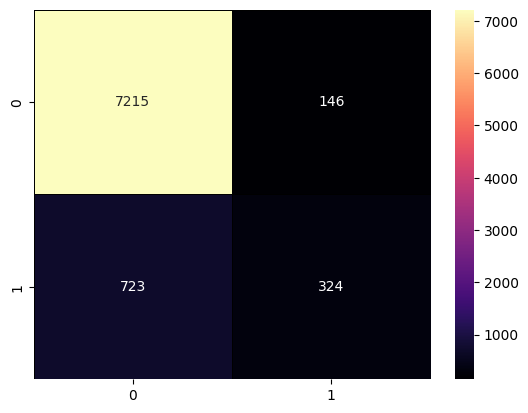

all


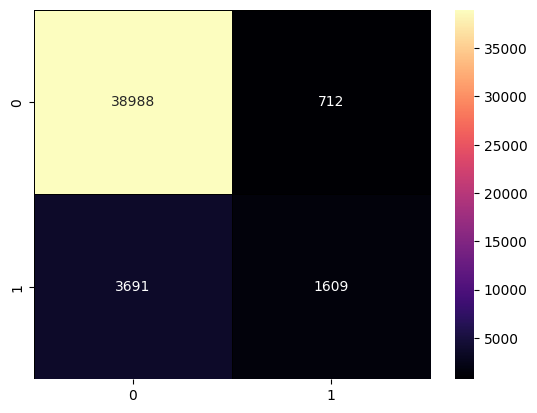

catch


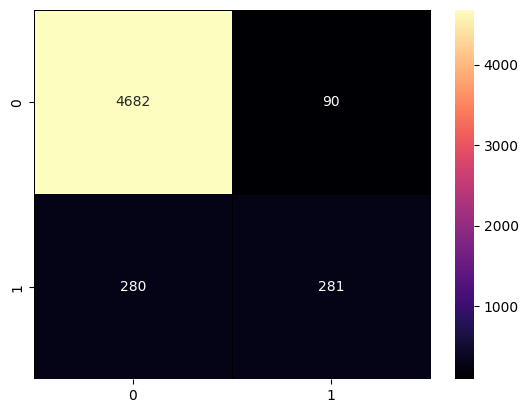

In [417]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Define models and datasets
models_data = {
    "handoff": (after_handoff_model, X_test_handoff, y_test_handoff),
    "all": (after_all_model, X_test_all, y_test_all),
    "catch": (after_catch_model, X_test_catch, y_test_catch)
}

# Define scoring metrics and corresponding functions
metrics = {
    "accuracy": accuracy_score,
    "precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average=None, zero_division=0),
    "recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average=None, zero_division=0),
    "f1": lambda y_true, y_pred: f1_score(y_true, y_pred, average=None, zero_division=0)
}

# Store results
results = {}

# Loop through models and datasets
for name, (model, train, test) in models_data.items():
    best_threshold = 0.5
    best_f1 = 0
    y_prob = model.predict_proba(train)[:, 1]

    y_pred_adjusted = (y_prob >=  best_threshold).astype(int)
    cm = confusion_matrix(test, y_pred_adjusted)
    sns.heatmap(cm, annot=True, fmt="d", cmap="magma", linewidths=0.5, linecolor='black')


    print(name)
    plt.show()


    # Compute metrics for each class
    results[name] = {}
    for metric_name, metric_func in metrics.items():
        values = metric_func(test, y_pred_adjusted)
        results[name]['best_threshold'] = best_threshold
        if metric_name == "accuracy":
            results[name]["accuracy"] = values  # Accuracy is not per class
        else:
            results[name][f"{metric_name}_class_0"] = values[0]  # Negative class (no play made)
            results[name][f"{metric_name}_class_1"] = values[1]  # Positive class (play made)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(results, orient='index')



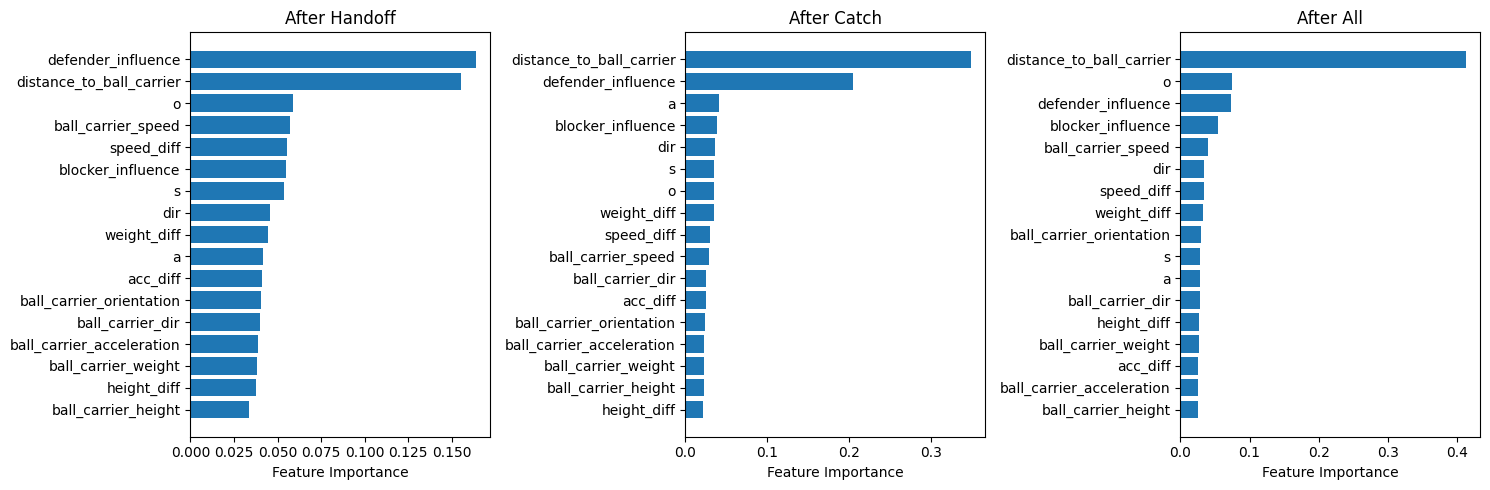

In [418]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Extract XGBoost models from pipelines
xgboost_models = {
    "After Handoff": after_handoff_model.best_estimator_,
    "After Catch": after_catch_model.best_estimator_,
    "After All": after_all_model.best_estimator_,
}

import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importance
def plot_feature_importance(model, feature_names, title, ax):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()

    ax.barh([feature_names[i] for i in sorted_idx], importances[sorted_idx])
    ax.set_title(title)
    ax.set_xlabel("Feature Importance")

# Feature names (assuming all models use the same features)
feature_names = after_handoff_model.best_estimator_.feature_names_in_

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for each model
for ax, (title, model) in zip(axes, xgboost_models.items()):
    plot_feature_importance(model, feature_names, title, ax)

plt.tight_layout()
plt.show()

#Feature importanc